# Named-Entity Recognition
Implementation of a NER tagger following Chiu-Nichols' paper (2016): 
Named Entity Recognition with Bidirectional LSTM-CNNs.

Author: Pierre Nugues

## A Note on the Performance

Chiu and Nichols reported a maximal performance of 91.62 on the CoNLL 2003 English corpus. The performance we obtain here is not completely comparable to theirs as we have a slightly different configuration.

The program below uses word and character features only. It sets aside the capitalization and lexicons features proposed by Chiu and Nichols. We believe this makes our program more easily adaptable to other languages. In addition, Chiu and Nichols trained their model on the training and development sets. We only use the training set.

Nonetheless, we can try to compare their figures with ours. In Table 6 of their paper, Chiu and Nichols report a best performance of 91.62 with a model trained on the training and development sets with all the features. When trained on the training set, they reached 91.23 (Table 8). From this, we can estimate that the contribution of the development set is of about 91.62 - 91.23 ~= 0.39. 

When using the word and character features and training their model on the training and development sets, Chiu and Nichols trained 90.91 (Table 6, second row, BLSTM-CNN). We can posit that Chiu and Nichols' system trained on the training set only would reach 90.91 - 0.39 ~= 90.52.

## Preliminaries

The imported modules

In [1]:
import sys
import os
import time
import numpy as np
from tqdm import tqdm
from random import shuffle
from keras import callbacks
from keras.initializers import RandomUniform
from keras.models import Sequential, Input
from keras.layers import Embedding, Flatten, Dense, Dropout, Lambda, TimeDistributed, concatenate
from keras.layers import LSTM, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D
from keras.optimizers import RMSprop
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras_contrib.layers import CRF
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Using TensorFlow backend.


A few functions we'll be using

In [2]:
sys.path.append('/Users/pierre/Documents/Cours/EDAN20/programs/')

from ch06.python.conll_dictorizer import CoNLLDictorizer
from ch08.python.datasets import load_conll2003_en, load_glove_vectors
from ch08.python.rnn_preprocessing import build_sequences, to_index, to_char_index

Different possible configurations, including those from Chiu-Nichols

In [3]:
OPTIMIZER = 'rmsprop'
ANNOTATION = 'IOBES'  # 'IOBES' or 'IOB'
EMBEDDING_DIM = 100
BATCH_SIZE =  512 # Chiu-Nichols 8
EPOCHS = 80 # Chiu-Nichols 80
LSTM_UNITS = 200 # Chiu-Nichols 275
CHAR_EMBEDDING_DIM = 50  # Chiu-Nichols 25
CHAR_UNITS = 50  # Chiu-Nichols 53
CHAR_DROPOUT = 0.5 # Chiu-Nichols 0?
DROPOUT_RATE_PRE = 0.5 # Dropout before the LSTM
RECURRENT_DROPOUT = 0.5 # Chiu-Nichols 0?
DROPOUT_RATE = 0.0 # Chiu-Nichols 0.68?
DROPOUT_RATE_POST = 0.0 # Dropout after the LSTM # Chiu-Nichols 0.0?
MAX_LEN_CHARS = 20 # 10 or 20
RAND_INIT_RANGE = 0.05
add_CRF = True

VILDE = False  # The computing machine

config = {'Optimizer': OPTIMIZER, 'Annotation': ANNOTATION,
          'Batch size': BATCH_SIZE, 'Epochs': EPOCHS, 'LSTM units': LSTM_UNITS,
          'Char embedding dim': CHAR_EMBEDDING_DIM, 'Embedding dim': EMBEDDING_DIM,
         'Char dropout': CHAR_DROPOUT, 'Pre dropout': DROPOUT_RATE_PRE, 
          'Recurrent dropout': RECURRENT_DROPOUT, 'Dropout': DROPOUT_RATE, 
          'Post dropout': DROPOUT_RATE_POST}

In [4]:
np.random.seed(0)
tf.random.set_seed(0)

## Creating the $\mathbf{X}$ and $\mathbf{Y}$ matrices

In [5]:
print('Configuration::', config)
start_time = time.perf_counter()
if ANNOTATION == 'IOBES':
    if VILDE:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(
            BASE_DIR='./')
    else:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(BASE_DIR='./IOBES/')
else:
    if VILDE:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(
            BASE_DIR='/home/pierre/Cours/EDAN20/corpus/CoNLL2003/')
    else:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(
            BASE_DIR='/Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/IOB/')

conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)
print('Second sentence, CoNLL rows:', train_dict[1])

X_train_word_cat, Y_train_cat = build_sequences(train_dict, key_x='form', key_y='ner', tolower=False)
X_dev_word_cat, Y_dev_cat = build_sequences(dev_dict, key_x='form', key_y='ner', tolower=False)
X_test_word_cat, Y_test_cat = build_sequences(test_dict, key_x='form', key_y='ner', tolower=False)
print('Second sentence, words', X_train_word_cat[1])
print('Second sentence, NER', Y_train_cat[1])

# We collect the words, named entity tags, and we create the indices
vocabulary_words_train = [word
                               for sentence in X_train_word_cat
                               for word in sentence]
vocabulary_words_dev = [word
                               for sentence in X_dev_word_cat
                               for word in sentence]
vocabulary_words_test = [word
                               for sentence in X_test_word_cat
                               for word in sentence]

Configuration:: {'Optimizer': 'rmsprop', 'Annotation': 'IOBES', 'Batch size': 512, 'Epochs': 80, 'LSTM units': 200, 'Char embedding dim': 50, 'Embedding dim': 100, 'Char dropout': 0.5, 'Pre dropout': 0.5, 'Recurrent dropout': 0.5, 'Dropout': 0.0, 'Post dropout': 0.0}
Second sentence, CoNLL rows: [{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'S-NP', 'ner': 'S-ORG'}, {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'S-VP', 'ner': 'O'}, {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'S-MISC'}, {'form': 'call', 'ppos': 'NN', 'pchunk': 'E-NP', 'ner': 'O'}, {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'E-VP', 'ner': 'O'}, {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'S-MISC'}, {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'E-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]
Second sentence, words ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Second sentence, NER ['S-ORG

As vocabulary, we first extract the words in the training set

In [6]:
vocabulary_words = vocabulary_words_train
#vocabulary_words.extend(vocabulary_words_dev)
#vocabulary_words.extend(vocabulary_words_test)
vocabulary_words = list(set(vocabulary_words))
print('#words:', len(vocabulary_words))

#words: 23624


We extract all the characters

In [7]:
MAX_LEN_CHARS_OBSERVED = max([len(word) for word in vocabulary_words])
print('Word maximal length', MAX_LEN_CHARS_OBSERVED)
chars = set(' ')
for word in vocabulary_words:
    chars.update(set(word))
chars = sorted(list(chars))

NB_CHARS = len(chars)
print('#chars:', NB_CHARS)

Word maximal length 61
#chars: 85


We build the complete vocabulary: the words from the training set and those from glove

In [8]:
# We read the embeddings
if VILDE:
    embeddings_dict = load_glove_vectors(
        BASE_DIR='/home/pierre/Cours/EDAN20/corpus/')
else:
    embeddings_dict = load_glove_vectors()
embeddings_words = embeddings_dict.keys()
print('#words in GloVe:', len(embeddings_dict.keys()))
vocabulary_words = sorted(set(vocabulary_words +
                              list(embeddings_words)))
print('# unique words in the vocabulary: embeddings and corpus:',
      len(vocabulary_words))

#words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 411650


We set all the words in lowed case

In [9]:
vocabulary_words = set(map(str.lower, vocabulary_words))
print('# unique lowercased words in the vocabulary: embeddings and corpus:',
      len(vocabulary_words))

# unique lowercased words in the vocabulary: embeddings and corpus: 402595


We extract all the named entity tags: The classes

In [10]:
ner = sorted(set([ner
                  for sentence in Y_train_cat
                  for ner in sentence]))
NB_CLASSES = len(ner)
print(NB_CLASSES, 'named entity tags:', ner)

17 named entity tags: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'E-LOC', 'E-MISC', 'E-ORG', 'E-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O', 'S-LOC', 'S-MISC', 'S-ORG', 'S-PER']


In [11]:
# We create the indexes
# For the words and chars, we start at two to make provision for
# the padding symbol 0 in RNN and LSTMs and unknown words/chars, 1
idx2char = dict(enumerate(chars, start=2))
idx2word = dict(enumerate(vocabulary_words, start=2))
idx2ner = dict(enumerate(ner))
char2idx = {v: k for k, v in idx2char.items()}
word2idx = {v: k for k, v in idx2word.items()}
ner2idx = {v: k for k, v in idx2ner.items()}
print('char index:', list(char2idx.items())[:10])
print('word index:', list(word2idx.items())[:10])
print('NER index:', list(ner2idx.items()))

char index: [(' ', 2), ('!', 3), ('"', 4), ('$', 5), ('%', 6), ('&', 7), ("'", 8), ('(', 9), (')', 10), ('*', 11)]
word index: [('record-holder', 2), ('pajaritos', 3), ('efsf', 4), ('kayes', 5), ('peche', 6), ('bides', 7), ('traille', 8), ('googe', 9), ('polish-german', 10), ('pichia', 11)]
NER index: [('B-LOC', 0), ('B-MISC', 1), ('B-ORG', 2), ('B-PER', 3), ('E-LOC', 4), ('E-MISC', 5), ('E-ORG', 6), ('E-PER', 7), ('I-LOC', 8), ('I-MISC', 9), ('I-ORG', 10), ('I-PER', 11), ('O', 12), ('S-LOC', 13), ('S-MISC', 14), ('S-ORG', 15), ('S-PER', 16)]


In [12]:
# We create the parallel sequences of indexes for the chars in their original case
X_train_char_idx = to_char_index(X_train_word_cat, char2idx)
X_train_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                            X_train_char_idx))
X_dev_char_idx = to_char_index(X_dev_word_cat, char2idx)
X_dev_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                          X_dev_char_idx))
X_test_char_idx = to_char_index(X_test_word_cat, char2idx)
X_test_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                           X_test_char_idx))

In [13]:
print(MAX_LEN_CHARS)
print(X_train_word_cat[1])
X_train_char_idx[1]

20
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


array([[36, 52,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [78, 65, 70, 65, 63, 80, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [38, 65, 78, 73, 61, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [63, 61, 72, 72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [80, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [62, 75, 85, 63, 75, 80, 80,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [33, 78, 69, 80, 69, 79, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [72, 61, 73, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32)

In [14]:
# We set the words in lower case.
X_train_word_cat = [[x.lower() for x in x_vect] for x_vect in X_train_word_cat]
X_dev_word_cat = [[x.lower() for x in x_vect] for x_vect in X_dev_word_cat]
X_test_word_cat = [[x.lower() for x in x_vect] for x_vect in X_test_word_cat]

In [15]:
X_train_word_cat[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [16]:
# We create the parallel sequences of indexes for the words
# Train
X_train_word_idx = to_index(X_train_word_cat, word2idx)
Y_train_idx = to_index(Y_train_cat, ner2idx)
# Dev
X_dev_word_idx = to_index(X_dev_word_cat, word2idx)
Y_dev_idx = to_index(Y_dev_cat, ner2idx)
# Test
X_test_word_idx = to_index(X_test_word_cat, word2idx)
Y_test_idx = to_index(Y_test_cat, ner2idx)

In [17]:
print('Train: X_word, Y')
print('Word indices:', X_train_word_idx[:2])
print('NER indices:', Y_train_idx[:2])
print('Dev: X_word, Y')
print('Word indices:', X_dev_word_idx[:2])
print('NER indices:', Y_dev_idx[:2])
print('Test: X_word, Y')
print('Word indices:', X_test_word_idx[:2])
print('NER indices:', Y_test_idx[:2])

Train: X_word, Y
Word indices: [[238822], [136963, 31438, 327393, 641, 261933, 268624, 201917, 144338, 386439]]
NER indices: [[12], [15, 12, 14, 12, 12, 12, 14, 12, 12]]
Dev: X_word, Y
Word indices: [[238822], [361227, 368797, 175345, 33200, 4732, 2870, 120737, 166426, 207083, 221915, 386439]]
NER indices: [[12], [12, 12, 15, 12, 12, 12, 12, 12, 12, 12, 12]]
Test: X_word, Y
Word indices: [[238822], [288547, 368797, 82546, 220992, 35070, 206693, 101093, 69649, 240908, 311124, 208793, 386439]]
NER indices: [[12], [12, 12, 13, 12, 12, 12, 12, 16, 12, 12, 12, 12]]


In [18]:
print('Train X_chars:', X_train_char_idx[:2])
print('Dev X_chars:', X_dev_char_idx[:2])
print('Test X_chars:', X_test_char_idx[:2])

Train X_chars: [array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), array([[36, 52,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [78, 65, 70, 65, 63, 80, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [38, 65, 78, 73, 61, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [63, 61, 72, 72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [80, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [62, 75, 85, 63, 75, 80, 80,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [33, 78, 69, 80, 69, 79, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [72, 61, 73, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]]

We initialize the embedding matrix with random values

In [19]:
embedding_matrix = np.random.uniform(-RAND_INIT_RANGE, RAND_INIT_RANGE,
                                     (len(vocabulary_words) + 2,
                                      EMBEDDING_DIM)
                                     ).astype(np.float32)
#embedding_matrix[0, :] = 0.0

In [20]:
# We assign the matrix with Glove embeddings, when they exist
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word2idx[word]] = embeddings_dict[word]

Embeddings

In [21]:
# print('Embedding:', embedding_matrix)
print('Shape of embedding matrix:', embedding_matrix.shape)
print('table:', embedding_matrix[word2idx['table']])
print('padding symbol, idx 0, random numbers:', embedding_matrix[0])
#print('Index of jean-denis:', word2idx['jean-denis'])

Shape of embedding matrix: (402597, 100)
table: [-0.61454    0.89693    0.56771    0.39102   -0.22437    0.49035
  0.10868    0.27411   -0.23833   -0.52153    0.73551   -0.32654
  0.51304    0.32415   -0.46709    0.68051   -0.25497   -0.040484
 -0.54418   -1.0548    -0.46692    0.23557    0.31234   -0.34537
  0.14793   -0.53745   -0.43215   -0.48724   -0.51019   -0.9051
 -0.17919   -0.018376   0.09719   -0.31623    0.7512     0.92236
 -0.49965    0.14036   -0.28296   -0.97443   -0.0094408 -0.62944
  0.14711   -0.94376    0.0075222  0.18565   -0.99172    0.072789
 -0.18474   -0.52901    0.38995   -0.45677   -0.21932    1.3723
 -0.29636   -2.2342    -0.36667    0.04987    0.63421    0.53275
 -0.53955    0.31398   -0.44698   -0.38389    0.066668  -0.02168
  0.20558    0.59456   -0.24892   -0.52795   -0.3761     0.077104
  0.75222   -0.2647    -0.0587     0.67541   -0.16559   -0.49278
 -0.26327   -0.21215    0.24317    0.17006   -0.2926    -0.5009
 -0.56638   -0.40377   -0.48452   -0.32539

We will create batches of identical size. When all the sentence in a batch have an identical size, we will avoid padding the sentence.

The first step is to sort the training set by sentence length

In [22]:
training_set_sorted = sorted(zip(X_train_word_idx, 
                           X_train_char_idx, 
                           Y_train_idx), 
                       key=lambda x: len(x[0]))

In [23]:
training_set_sorted[:5]

[([238822],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([386439],
  array([[15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([238822],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([238822],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([238822],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12])]

## The Architecture

We implement Chiu and Nichols' model

In [24]:
# char input
char_input = Input(shape=(None, MAX_LEN_CHARS,))
embedded_char = TimeDistributed(
    Embedding(NB_CHARS + 2,
              CHAR_EMBEDDING_DIM,
              trainable=True,
              embeddings_initializer=RandomUniform(minval=-RAND_INIT_RANGE, 
                                                   maxval=RAND_INIT_RANGE)))(char_input)
embedded_char = Dropout(CHAR_DROPOUT)(embedded_char)
conv = TimeDistributed(
    Conv1D(kernel_size=3,
           filters=CHAR_UNITS,
           activation='tanh',
           padding='same'))(embedded_char)
maxpool = TimeDistributed(MaxPooling1D(MAX_LEN_CHARS))(conv)
char_encoding = TimeDistributed(Flatten())(maxpool)
#char_encoding = Dropout(CHAR_DROPOUT)(char_encoding)
# word input
word_input = Input(shape=(None,))
embedded_word = Embedding(len(vocabulary_words) + 2,
                          EMBEDDING_DIM,
                          trainable=True,
                          #mask_zero=True, # Removed for CRF
                          weights=[embedding_matrix])(word_input)
# Because of a bug in the CRF layer, we must set mask_zero to FALSE
if add_CRF:
    embedded_word._keras_mask = False
# embedded_word = Dropout(DROPOUT_RATE)(embedded_word)
model = concatenate([char_encoding, embedded_word])
model = Dropout(DROPOUT_RATE_PRE)(model)
model = Bidirectional(LSTM(LSTM_UNITS,
                           return_sequences=True,
                           dropout=DROPOUT_RATE,
                           recurrent_dropout=RECURRENT_DROPOUT))(model)
#model = Dense(100, activation='relu')(model)
model = Dropout(DROPOUT_RATE_POST)(model)
if add_CRF:
    out = Dense(len(ner), activation='relu')(model)
    crf = CRF(len(ner))  # CRF layer
    out = crf(out)  # output
else:
    out = Dense(len(ner), activation='softmax')(model)
model = Model([char_input, word_input], out)

In [25]:
if add_CRF:
    model.compile(optimizer='rmsprop',
                      loss=crf.loss_function,
                      metrics=[crf.accuracy])
else:
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 20)     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 20, 50) 4350        input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 20, 50) 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, None, 20, 50) 7550        dropout_1[0][0]                  
____________________________________________________________________________________________

/Users/pierre/opt/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/pierre/opt/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


## Creating the Batches

We now create the histogram of sentence lengths. `groupby` is like the `uniq -c` shell command. We obtain a list of pairs: (sentence length, count of sentences that have this length)

In [26]:
from itertools import groupby
train_sent_len_list = list(map(lambda x: len(x[0]), training_set_sorted))
train_length_hist = [(x[0], len(list(x[1]))) for x in groupby(train_sent_len_list)]
train_length_hist[:10]

[(1, 1125),
 (2, 1129),
 (3, 586),
 (4, 771),
 (5, 751),
 (6, 625),
 (7, 904),
 (8, 1056),
 (9, 894),
 (10, 503)]

<BarContainer object of 64 artists>

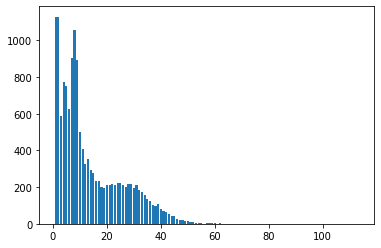

In [27]:
plt.bar(list(map(lambda x: x[0], train_length_hist)),
        list(map(lambda x: x[1], train_length_hist)))

We create bins of sentences of the same length. This is to avoid padding

In [28]:
training_bins = []
for bin in train_length_hist:
    training_bins += [training_set_sorted[:bin[1]]]
    training_set_sorted = training_set_sorted[bin[1]:]

## Training the Model

We now create a generator to generate batches of sentences with the same length

In [29]:
def minibatch_generator(dataset):
    #shuffle(dataset)
    # We take the sentences of the same length
    for sentence_bin in dataset:
        #shuffle(sentence_bin)
        # The number of batches. 
        batch_cnt = int(np.ceil((len(sentence_bin) / BATCH_SIZE)))
        # We create batches of BATCH_SIZE
        for j in range(batch_cnt):
            char_batch = []
            token_batch = []
            label_batch = []
            for sentence in sentence_bin[j*BATCH_SIZE:(j+1)*BATCH_SIZE]:
                tokens, chars, labels = sentence
                char_batch.append(chars)
                token_batch.append(tokens)
                label_batch.append(labels)
            label_batch = list(map(lambda x: np.transpose([x]), label_batch))
            label_batch = to_categorical(label_batch, num_classes=len(ner))
            yield  np.asarray(char_batch), np.asarray(token_batch), label_batch

In [30]:
model.metrics_names

['loss', 'crf_viterbi_accuracy']

In [31]:
def predict(X_char_idx, X_word_idx, model, idx2pos, default_tag='O'):
    """
    Function to predict the test set and converts the indices to symbols
    """

    Y_pred_vect = []
    for x_char, x_word in zip(X_char_idx, X_word_idx):
        y_pred_vect = model.predict([np.array([x_char]),
                                          np.array([x_word])])[0]
        Y_pred_vect += [y_pred_vect]

    # print('Y_test_pred_vect', Y_test_pred_vect[:2])
    # Convert to POS or NER idx to symbols
    Y_pred = []
    for y_pred_vect in Y_pred_vect:
        pos_idx = np.argmax(y_pred_vect, axis=-1)
        # print('POS_IDX', pos_idx)
        # We convert the indices into symbols
        # If the symbol does not exist, we tag the word with O, the default tag
        pos_cat = list(map(lambda x: idx2pos.get(x, default_tag), pos_idx))
        # We add a sanity check if the classifier has predicted a nonvalid tag.
        # This could only be the padding index: 0
        for pos in pos_idx:
            if pos not in idx2pos:
                print('Bad, should not occur:', pos)
                print((-y_pred_vect).argsort())
                print('Bad, should not occur:', y_pred_vect)
        Y_pred += [pos_cat]
    return Y_pred

With the next function, we format the words, the named entity tags, and the predicted named entity tags so that we can evaluate them. It necessary converts them to the IOBES tagset.

In [32]:
def format_conll(X_words, Y, Y_hat):
    total_words = 0
    correct = 0
    total_ukn = 0
    correct_ukn = 0
    conll_pred_corpus = ''
    
    for sent_nbr, y_vect_hat in enumerate(Y_hat):
        for word_nbr, y_hat in enumerate(y_vect_hat):
            unknown_word = False
            # y is the correct named entity tag
            y = Y[sent_nbr][word_nbr]
            if ANNOTATION == 'IOBES':
                if y[0] == 'S':
                    y = 'B' + y[1:]
                if y[0] == 'E':
                    y = 'I' + y[1:]
                if y_hat[0] == 'S':
                    y_hat = 'B' + y_hat[1:]
                if y_hat[0] == 'E':
                    y_hat = 'I' + y_hat[1:]
            line = ' '.join([X_words[sent_nbr][word_nbr],
                                     y, y_hat])
            line += '\n'
            total_words += 1
            conll_pred_corpus += line
            #file.write(line)
            # The word is not in the dictionary
            if X_words[sent_nbr][word_nbr] not in word2idx:
                total_ukn += 1
                unknown_word = True
            if y_hat == y:
                correct += 1
                if unknown_word:
                    correct_ukn += 1
        conll_pred_corpus += '\n'
        #file.write('\n')
    print('total %d, correct %d, accuracy %f' % (total_words, correct, correct / total_words))
    if total_ukn != 0:
        print('total unknown %d, correct %d, accuracy %f' % (total_ukn, correct_ukn, correct_ukn / total_ukn))
    return conll_pred_corpus

In [ ]:
for epoch in range(EPOCHS):    
    print("Epoch {}/{}".format(epoch + 1, EPOCHS))
    for i, batch in tqdm(enumerate(minibatch_generator(training_bins))):
        char_batch, token_batch, label_batch = batch  
        loss = model.train_on_batch([char_batch, token_batch], 
                                    label_batch)

    # We evaluate the dev set
    print('CoNLL score dev set')
    Y_dev_hat = predict(X_dev_char_idx, X_dev_word_idx, model, idx2ner)
    conll_dev_pred = format_conll(X_dev_word_cat, Y_dev_cat, Y_dev_hat)
    
    signature = '_' + str(CHAR_DROPOUT) + '_' + str(DROPOUT_RATE_PRE) + '_' +\
    str(RECURRENT_DROPOUT) + '_' + str(DROPOUT_RATE) + '_' + str(DROPOUT_RATE_POST) + '_'
    
    outfile = 'dev' + signature + '.out'
    with open(outfile, 'w') as file:
        file.write(conll_dev_pred)
    print(os.popen('perl -w conlleval.pl <' + outfile).read())
    
    # We evaluate the test set
    print('CoNLL score test set')
    Y_test_hat = predict(X_test_char_idx, X_test_word_idx, model, idx2ner)
    conll_test_pred = format_conll(X_test_word_cat, Y_test_cat, Y_test_hat)
    
    outfile = 'test' + signature + '.out'
    with open(outfile, 'w') as file:
        file.write(conll_test_pred)
    print(os.popen('perl -w conlleval.pl <' + outfile).read())

0it [00:00, ?it/s]

Epoch 1/80


/Users/pierre/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
76it [00:36,  2.06it/s]


CoNLL score dev set
total 51578, correct 43744, accuracy 0.848114
total unknown 713, correct 515, accuracy 0.722300
processed 51578 tokens with 5942 phrases; found: 1151 phrases; correct: 533.
accuracy:  84.81%; precision:  46.31%; recall:   8.97%; FB1:  15.03
              LOC: precision:  88.64%; recall:  13.17%; FB1:  22.94  273
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  12
              ORG: precision:  67.63%; recall:   7.01%; FB1:  12.70  139
              PER: precision:  27.10%; recall:  10.69%; FB1:  15.34  727

CoNLL score test set
total 46666, correct 39331, accuracy 0.842819
total unknown 1143, correct 857, accuracy 0.749781


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 1231 phrases; correct: 532.
accuracy:  84.28%; precision:  43.22%; recall:   9.42%; FB1:  15.47
              LOC: precision:  75.08%; recall:  14.99%; FB1:  24.99  333
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  13
              ORG: precision:  40.00%; recall:   4.70%; FB1:   8.41  195
              PER: precision:  29.57%; recall:  12.62%; FB1:  17.69  690

Epoch 2/80


76it [00:33,  2.24it/s]


CoNLL score dev set
total 51578, correct 46105, accuracy 0.893889
total unknown 713, correct 545, accuracy 0.764376
processed 51578 tokens with 5942 phrases; found: 2975 phrases; correct: 2111.
accuracy:  89.39%; precision:  70.96%; recall:  35.53%; FB1:  47.35
              LOC: precision:  85.66%; recall:  45.51%; FB1:  59.44  976
             MISC: precision:  84.42%; recall:   7.05%; FB1:  13.01  77
              ORG: precision:  67.07%; recall:  24.76%; FB1:  36.17  495
              PER: precision:  61.53%; recall:  47.67%; FB1:  53.72  1427

CoNLL score test set
total 46666, correct 41417, accuracy 0.887520
total unknown 1143, correct 912, accuracy 0.797900


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 2926 phrases; correct: 1921.
accuracy:  88.75%; precision:  65.65%; recall:  34.01%; FB1:  44.81
              LOC: precision:  77.54%; recall:  43.47%; FB1:  55.70  935
             MISC: precision:  73.91%; recall:   4.84%; FB1:   9.09  46
              ORG: precision:  54.41%; recall:  24.86%; FB1:  34.13  759
              PER: precision:  63.15%; recall:  46.32%; FB1:  53.44  1186

Epoch 3/80


76it [00:33,  2.27it/s]


CoNLL score dev set
total 51578, correct 47948, accuracy 0.929621
total unknown 713, correct 609, accuracy 0.854137
processed 51578 tokens with 5942 phrases; found: 4902 phrases; correct: 3659.
accuracy:  92.96%; precision:  74.64%; recall:  61.58%; FB1:  67.48
              LOC: precision:  81.00%; recall:  71.69%; FB1:  76.06  1626
             MISC: precision:  77.84%; recall:  32.75%; FB1:  46.11  388
              ORG: precision:  53.90%; recall:  48.40%; FB1:  51.00  1204
              PER: precision:  82.60%; recall:  75.52%; FB1:  78.90  1684

CoNLL score test set
total 46666, correct 43059, accuracy 0.922706
total unknown 1143, correct 985, accuracy 0.861767


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 4950 phrases; correct: 3329.
accuracy:  92.27%; precision:  67.25%; recall:  58.94%; FB1:  62.82
              LOC: precision:  73.19%; recall:  71.34%; FB1:  72.25  1626
             MISC: precision:  72.55%; recall:  31.62%; FB1:  44.05  306
              ORG: precision:  48.06%; recall:  46.12%; FB1:  47.07  1594
              PER: precision:  80.83%; recall:  71.18%; FB1:  75.70  1424

Epoch 4/80


76it [00:34,  2.23it/s]


CoNLL score dev set
total 51578, correct 48811, accuracy 0.946353
total unknown 713, correct 628, accuracy 0.880785
processed 51578 tokens with 5942 phrases; found: 5409 phrases; correct: 4290.
accuracy:  94.64%; precision:  79.31%; recall:  72.20%; FB1:  75.59
              LOC: precision:  85.81%; recall:  83.61%; FB1:  84.70  1790
             MISC: precision:  78.66%; recall:  45.99%; FB1:  58.04  539
              ORG: precision:  64.54%; recall:  56.60%; FB1:  60.31  1176
              PER: precision:  82.51%; recall:  85.29%; FB1:  83.88  1904

CoNLL score test set
total 46666, correct 43893, accuracy 0.940578
total unknown 1143, correct 1004, accuracy 0.878390


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5448 phrases; correct: 3943.
accuracy:  94.06%; precision:  72.38%; recall:  69.81%; FB1:  71.07
              LOC: precision:  78.24%; recall:  81.71%; FB1:  79.94  1742
             MISC: precision:  68.29%; recall:  46.01%; FB1:  54.98  473
              ORG: precision:  58.10%; recall:  56.11%; FB1:  57.09  1604
              PER: precision:  81.34%; recall:  81.94%; FB1:  81.64  1629

Epoch 5/80


76it [00:33,  2.25it/s]


CoNLL score dev set
total 51578, correct 49238, accuracy 0.954632
total unknown 713, correct 628, accuracy 0.880785
processed 51578 tokens with 5942 phrases; found: 5458 phrases; correct: 4502.
accuracy:  95.46%; precision:  82.48%; recall:  75.77%; FB1:  78.98
              LOC: precision:  90.02%; recall:  82.47%; FB1:  86.08  1683
             MISC: precision:  81.42%; recall:  56.07%; FB1:  66.41  635
              ORG: precision:  66.04%; recall:  65.85%; FB1:  65.94  1337
              PER: precision:  88.02%; recall:  86.16%; FB1:  87.08  1803

CoNLL score test set
total 46666, correct 44185, accuracy 0.946835
total unknown 1143, correct 1006, accuracy 0.880140


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5405 phrases; correct: 4106.
accuracy:  94.68%; precision:  75.97%; recall:  72.70%; FB1:  74.30
              LOC: precision:  84.62%; recall:  80.82%; FB1:  82.67  1593
             MISC: precision:  71.16%; recall:  53.42%; FB1:  61.03  527
              ORG: precision:  61.57%; recall:  65.20%; FB1:  63.33  1759
              PER: precision:  85.19%; recall:  80.40%; FB1:  82.72  1526

Epoch 6/80


76it [00:34,  2.21it/s]


CoNLL score dev set
total 51578, correct 49747, accuracy 0.964500
total unknown 713, correct 640, accuracy 0.897616
processed 51578 tokens with 5942 phrases; found: 5890 phrases; correct: 4888.
accuracy:  96.45%; precision:  82.99%; recall:  82.26%; FB1:  82.62
              LOC: precision:  89.07%; recall:  87.81%; FB1:  88.43  1811
             MISC: precision:  84.58%; recall:  62.47%; FB1:  71.87  681
              ORG: precision:  67.56%; recall:  74.87%; FB1:  71.03  1486
              PER: precision:  88.65%; recall:  92.02%; FB1:  90.30  1912

CoNLL score test set
total 46666, correct 44686, accuracy 0.957571
total unknown 1143, correct 1026, accuracy 0.897638


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5726 phrases; correct: 4554.
accuracy:  95.76%; precision:  79.53%; recall:  80.63%; FB1:  80.08
              LOC: precision:  84.79%; recall:  87.23%; FB1:  85.99  1716
             MISC: precision:  75.66%; recall:  57.55%; FB1:  65.37  534
              ORG: precision:  67.50%; recall:  76.16%; FB1:  71.57  1874
              PER: precision:  89.26%; recall:  88.44%; FB1:  88.85  1602

Epoch 7/80


76it [00:33,  2.24it/s]


CoNLL score dev set
total 51578, correct 49947, accuracy 0.968378
total unknown 713, correct 650, accuracy 0.911641
processed 51578 tokens with 5942 phrases; found: 6048 phrases; correct: 5053.
accuracy:  96.84%; precision:  83.55%; recall:  85.04%; FB1:  84.29
              LOC: precision:  92.18%; recall:  87.92%; FB1:  90.00  1752
             MISC: precision:  85.14%; recall:  66.49%; FB1:  74.67  720
              ORG: precision:  69.13%; recall:  82.33%; FB1:  75.15  1597
              PER: precision:  86.96%; recall:  93.43%; FB1:  90.08  1979

CoNLL score test set
total 46666, correct 44816, accuracy 0.960357
total unknown 1143, correct 1021, accuracy 0.893263


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5832 phrases; correct: 4699.
accuracy:  96.04%; precision:  80.57%; recall:  83.20%; FB1:  81.86
              LOC: precision:  87.88%; recall:  86.93%; FB1:  87.40  1650
             MISC: precision:  77.25%; recall:  62.39%; FB1:  69.03  567
              ORG: precision:  69.55%; recall:  80.85%; FB1:  74.78  1931
              PER: precision:  87.17%; recall:  90.79%; FB1:  88.94  1684

Epoch 8/80


76it [00:34,  2.21it/s]


CoNLL score dev set
total 51578, correct 50115, accuracy 0.971635
total unknown 713, correct 652, accuracy 0.914446
processed 51578 tokens with 5942 phrases; found: 6220 phrases; correct: 5210.
accuracy:  97.16%; precision:  83.76%; recall:  87.68%; FB1:  85.68
              LOC: precision:  90.71%; recall:  90.91%; FB1:  90.81  1841
             MISC: precision:  86.64%; recall:  69.63%; FB1:  77.21  741
              ORG: precision:  68.38%; recall:  86.28%; FB1:  76.29  1692
              PER: precision:  89.47%; recall:  94.52%; FB1:  91.92  1946

CoNLL score test set
total 46666, correct 44892, accuracy 0.961985
total unknown 1143, correct 1029, accuracy 0.900262


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5987 phrases; correct: 4810.
accuracy:  96.20%; precision:  80.34%; recall:  85.16%; FB1:  82.68
              LOC: precision:  87.11%; recall:  89.15%; FB1:  88.12  1707
             MISC: precision:  75.93%; recall:  63.82%; FB1:  69.35  590
              ORG: precision:  67.93%; recall:  85.19%; FB1:  75.59  2083
              PER: precision:  90.85%; recall:  90.29%; FB1:  90.57  1607

Epoch 9/80


76it [00:34,  2.22it/s]


CoNLL score dev set
total 51578, correct 50125, accuracy 0.971829
total unknown 713, correct 652, accuracy 0.914446
processed 51578 tokens with 5942 phrases; found: 6139 phrases; correct: 5217.
accuracy:  97.18%; precision:  84.98%; recall:  87.80%; FB1:  86.37
              LOC: precision:  93.65%; recall:  89.87%; FB1:  91.72  1763
             MISC: precision:  88.37%; recall:  70.07%; FB1:  78.16  731
              ORG: precision:  68.87%; recall:  87.92%; FB1:  77.24  1712
              PER: precision:  90.07%; recall:  94.52%; FB1:  92.24  1933

CoNLL score test set
total 46666, correct 44919, accuracy 0.962564
total unknown 1143, correct 1033, accuracy 0.903762


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5923 phrases; correct: 4850.
accuracy:  96.26%; precision:  81.88%; recall:  85.87%; FB1:  83.83
              LOC: precision:  89.86%; recall:  89.27%; FB1:  89.56  1657
             MISC: precision:  77.38%; recall:  64.81%; FB1:  70.54  588
              ORG: precision:  69.72%; recall:  86.94%; FB1:  77.38  2071
              PER: precision:  90.98%; recall:  90.41%; FB1:  90.69  1607

Epoch 10/80


76it [00:34,  2.22it/s]


CoNLL score dev set
total 51578, correct 49949, accuracy 0.968417
total unknown 713, correct 651, accuracy 0.913043
processed 51578 tokens with 5942 phrases; found: 6230 phrases; correct: 5199.
accuracy:  96.84%; precision:  83.45%; recall:  87.50%; FB1:  85.43
              LOC: precision:  93.73%; recall:  89.44%; FB1:  91.53  1753
             MISC: precision:  89.56%; recall:  70.72%; FB1:  79.03  728
              ORG: precision:  65.55%; recall:  87.70%; FB1:  75.02  1794
              PER: precision:  88.39%; recall:  93.81%; FB1:  91.02  1955

CoNLL score test set
total 46666, correct 44686, accuracy 0.957571
total unknown 1143, correct 1024, accuracy 0.895888


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 6054 phrases; correct: 4825.
accuracy:  95.76%; precision:  79.70%; recall:  85.43%; FB1:  82.46
              LOC: precision:  90.21%; recall:  88.97%; FB1:  89.59  1645
             MISC: precision:  74.62%; recall:  63.25%; FB1:  68.47  595
              ORG: precision:  66.21%; recall:  87.66%; FB1:  75.44  2199
              PER: precision:  89.23%; recall:  89.12%; FB1:  89.17  1615

Epoch 11/80


76it [00:34,  2.23it/s]


CoNLL score dev set
total 51578, correct 50345, accuracy 0.976094
total unknown 713, correct 657, accuracy 0.921459
processed 51578 tokens with 5942 phrases; found: 6154 phrases; correct: 5365.
accuracy:  97.61%; precision:  87.18%; recall:  90.29%; FB1:  88.71
              LOC: precision:  93.66%; recall:  94.07%; FB1:  93.86  1845
             MISC: precision:  86.76%; recall:  76.03%; FB1:  81.04  808
              ORG: precision:  74.58%; recall:  89.26%; FB1:  81.26  1605
              PER: precision:  91.72%; recall:  94.41%; FB1:  93.04  1896

CoNLL score test set
total 46666, correct 45034, accuracy 0.965028
total unknown 1143, correct 1037, accuracy 0.907262


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5949 phrases; correct: 4922.
accuracy:  96.50%; precision:  82.74%; recall:  87.15%; FB1:  84.88
              LOC: precision:  89.24%; recall:  91.49%; FB1:  90.35  1710
             MISC: precision:  73.12%; recall:  67.81%; FB1:  70.36  651
              ORG: precision:  72.93%; recall:  87.60%; FB1:  79.60  1995
              PER: precision:  91.96%; recall:  90.60%; FB1:  91.28  1593

Epoch 12/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 50401, accuracy 0.977180
total unknown 713, correct 645, accuracy 0.904628
processed 51578 tokens with 5942 phrases; found: 6021 phrases; correct: 5276.
accuracy:  97.72%; precision:  87.63%; recall:  88.79%; FB1:  88.21
              LOC: precision:  96.21%; recall:  88.41%; FB1:  92.14  1688
             MISC: precision:  91.70%; recall:  75.49%; FB1:  82.81  759
              ORG: precision:  75.28%; recall:  89.26%; FB1:  81.68  1590
              PER: precision:  88.66%; recall:  95.49%; FB1:  91.95  1984

CoNLL score test set
total 46666, correct 45288, accuracy 0.970471
total unknown 1143, correct 1037, accuracy 0.907262


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5777 phrases; correct: 4939.
accuracy:  97.05%; precision:  85.49%; recall:  87.45%; FB1:  86.46
              LOC: precision:  93.90%; recall:  88.55%; FB1:  91.14  1573
             MISC: precision:  79.50%; recall:  68.52%; FB1:  73.60  605
              ORG: precision:  76.99%; recall:  88.44%; FB1:  82.32  1908
              PER: precision:  89.41%; recall:  93.51%; FB1:  91.41  1691

Epoch 13/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 50322, accuracy 0.975649
total unknown 713, correct 652, accuracy 0.914446
processed 51578 tokens with 5942 phrases; found: 6048 phrases; correct: 5312.
accuracy:  97.56%; precision:  87.83%; recall:  89.40%; FB1:  88.61
              LOC: precision:  95.64%; recall:  91.94%; FB1:  93.76  1766
             MISC: precision:  91.16%; recall:  73.86%; FB1:  81.61  747
              ORG: precision:  72.49%; recall:  89.78%; FB1:  80.21  1661
              PER: precision:  92.74%; recall:  94.35%; FB1:  93.54  1874

CoNLL score test set
total 46666, correct 45063, accuracy 0.965650
total unknown 1143, correct 1024, accuracy 0.895888


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5836 phrases; correct: 4878.
accuracy:  96.56%; precision:  83.58%; recall:  86.37%; FB1:  84.95
              LOC: precision:  92.17%; recall:  90.35%; FB1:  91.25  1635
             MISC: precision:  76.91%; recall:  64.53%; FB1:  70.18  589
              ORG: precision:  71.91%; recall:  89.10%; FB1:  79.59  2058
              PER: precision:  92.54%; recall:  88.93%; FB1:  90.70  1554

Epoch 14/80


76it [00:33,  2.24it/s]


CoNLL score dev set
total 51578, correct 50518, accuracy 0.979449
total unknown 713, correct 660, accuracy 0.925666
processed 51578 tokens with 5942 phrases; found: 6042 phrases; correct: 5405.
accuracy:  97.94%; precision:  89.46%; recall:  90.96%; FB1:  90.20
              LOC: precision:  94.86%; recall:  94.39%; FB1:  94.62  1828
             MISC: precision:  91.17%; recall:  76.14%; FB1:  82.98  770
              ORG: precision:  77.94%; recall:  90.08%; FB1:  83.57  1550
              PER: precision:  92.98%; recall:  95.60%; FB1:  94.27  1894

CoNLL score test set
total 46666, correct 45267, accuracy 0.970021
total unknown 1143, correct 1043, accuracy 0.912511


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5829 phrases; correct: 4984.
accuracy:  97.00%; precision:  85.50%; recall:  88.24%; FB1:  86.85
              LOC: precision:  90.38%; recall:  92.33%; FB1:  91.34  1704
             MISC: precision:  78.14%; recall:  68.23%; FB1:  72.85  613
              ORG: precision:  77.35%; recall:  88.62%; FB1:  82.60  1903
              PER: precision:  92.79%; recall:  92.33%; FB1:  92.56  1609

Epoch 15/80


76it [00:33,  2.24it/s]


CoNLL score dev set
total 51578, correct 50450, accuracy 0.978130
total unknown 713, correct 655, accuracy 0.918654
processed 51578 tokens with 5942 phrases; found: 5989 phrases; correct: 5358.
accuracy:  97.81%; precision:  89.46%; recall:  90.17%; FB1:  89.82
              LOC: precision:  96.98%; recall:  92.54%; FB1:  94.71  1753
             MISC: precision:  89.81%; recall:  78.42%; FB1:  83.73  805
              ORG: precision:  76.60%; recall:  89.34%; FB1:  82.48  1564
              PER: precision:  93.04%; recall:  94.30%; FB1:  93.66  1867

CoNLL score test set
total 46666, correct 45171, accuracy 0.967964
total unknown 1143, correct 1043, accuracy 0.912511


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5812 phrases; correct: 4937.
accuracy:  96.80%; precision:  84.94%; recall:  87.41%; FB1:  86.16
              LOC: precision:  93.55%; recall:  89.57%; FB1:  91.52  1597
             MISC: precision:  74.89%; recall:  70.09%; FB1:  72.41  657
              ORG: precision:  74.71%; recall:  89.28%; FB1:  81.35  1985
              PER: precision:  93.32%; recall:  90.79%; FB1:  92.04  1573

Epoch 16/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 50576, accuracy 0.980573
total unknown 713, correct 664, accuracy 0.931276
processed 51578 tokens with 5942 phrases; found: 5922 phrases; correct: 5389.
accuracy:  98.06%; precision:  91.00%; recall:  90.69%; FB1:  90.85
              LOC: precision:  96.44%; recall:  94.34%; FB1:  95.38  1797
             MISC: precision:  91.97%; recall:  77.01%; FB1:  83.83  772
              ORG: precision:  80.26%; recall:  88.81%; FB1:  84.32  1484
              PER: precision:  93.90%; recall:  95.28%; FB1:  94.58  1869

CoNLL score test set
total 46666, correct 45262, accuracy 0.969914
total unknown 1143, correct 1038, accuracy 0.908136


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5682 phrases; correct: 4920.
accuracy:  96.99%; precision:  86.59%; recall:  87.11%; FB1:  86.85
              LOC: precision:  92.02%; recall:  91.31%; FB1:  91.66  1655
             MISC: precision:  77.82%; recall:  65.95%; FB1:  71.40  595
              ORG: precision:  78.29%; recall:  87.06%; FB1:  82.44  1847
              PER: precision:  93.88%; recall:  92.02%; FB1:  92.94  1585

Epoch 17/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 50601, accuracy 0.981058
total unknown 713, correct 663, accuracy 0.929874
processed 51578 tokens with 5942 phrases; found: 6004 phrases; correct: 5407.
accuracy:  98.11%; precision:  90.06%; recall:  91.00%; FB1:  90.52
              LOC: precision:  95.92%; recall:  94.67%; FB1:  95.29  1813
             MISC: precision:  92.60%; recall:  76.03%; FB1:  83.50  757
              ORG: precision:  78.19%; recall:  90.38%; FB1:  83.85  1550
              PER: precision:  93.15%; recall:  95.28%; FB1:  94.20  1884

CoNLL score test set
total 46666, correct 45372, accuracy 0.972271
total unknown 1143, correct 1045, accuracy 0.914261


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5765 phrases; correct: 4986.
accuracy:  97.23%; precision:  86.49%; recall:  88.28%; FB1:  87.37
              LOC: precision:  91.62%; recall:  91.73%; FB1:  91.67  1670
             MISC: precision:  80.58%; recall:  66.81%; FB1:  73.05  582
              ORG: precision:  78.04%; recall:  90.07%; FB1:  83.62  1917
              PER: precision:  93.42%; recall:  92.21%; FB1:  92.81  1596

Epoch 18/80


76it [00:34,  2.21it/s]


CoNLL score dev set
total 51578, correct 50644, accuracy 0.981892
total unknown 713, correct 667, accuracy 0.935484
processed 51578 tokens with 5942 phrases; found: 5975 phrases; correct: 5419.
accuracy:  98.19%; precision:  90.69%; recall:  91.20%; FB1:  90.95
              LOC: precision:  96.30%; recall:  95.05%; FB1:  95.67  1813
             MISC: precision:  91.77%; recall:  74.95%; FB1:  82.51  753
              ORG: precision:  79.48%; recall:  90.98%; FB1:  84.84  1535
              PER: precision:  94.02%; recall:  95.66%; FB1:  94.83  1874

CoNLL score test set
total 46666, correct 45411, accuracy 0.973107
total unknown 1143, correct 1045, accuracy 0.914261


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5742 phrases; correct: 4993.
accuracy:  97.31%; precision:  86.96%; recall:  88.40%; FB1:  87.67
              LOC: precision:  91.67%; recall:  92.39%; FB1:  92.03  1681
             MISC: precision:  79.15%; recall:  66.52%; FB1:  72.29  590
              ORG: precision:  79.46%; recall:  89.64%; FB1:  84.24  1874
              PER: precision:  93.68%; recall:  92.52%; FB1:  93.09  1597

Epoch 19/80


76it [00:34,  2.23it/s]


CoNLL score dev set
total 51578, correct 50710, accuracy 0.983171
total unknown 713, correct 668, accuracy 0.936886
processed 51578 tokens with 5942 phrases; found: 6006 phrases; correct: 5460.
accuracy:  98.32%; precision:  90.91%; recall:  91.89%; FB1:  91.40
              LOC: precision:  96.20%; recall:  95.16%; FB1:  95.68  1817
             MISC: precision:  92.65%; recall:  77.98%; FB1:  84.69  776
              ORG: precision:  79.31%; recall:  92.02%; FB1:  85.19  1556
              PER: precision:  94.72%; recall:  95.49%; FB1:  95.11  1857

CoNLL score test set
total 46666, correct 45460, accuracy 0.974157
total unknown 1143, correct 1050, accuracy 0.918635


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5764 phrases; correct: 4998.
accuracy:  97.42%; precision:  86.71%; recall:  88.49%; FB1:  87.59
              LOC: precision:  91.99%; recall:  92.21%; FB1:  92.10  1672
             MISC: precision:  79.31%; recall:  68.80%; FB1:  73.68  609
              ORG: precision:  78.07%; recall:  90.67%; FB1:  83.90  1929
              PER: precision:  94.66%; recall:  90.97%; FB1:  92.78  1554

Epoch 20/80


76it [00:35,  2.16it/s]


CoNLL score dev set
total 51578, correct 50766, accuracy 0.984257
total unknown 713, correct 672, accuracy 0.942496
processed 51578 tokens with 5942 phrases; found: 6001 phrases; correct: 5502.
accuracy:  98.43%; precision:  91.68%; recall:  92.60%; FB1:  92.14
              LOC: precision:  96.62%; recall:  94.94%; FB1:  95.77  1805
             MISC: precision:  92.48%; recall:  82.75%; FB1:  87.35  825
              ORG: precision:  83.31%; recall:  91.20%; FB1:  87.08  1468
              PER: precision:  93.12%; recall:  96.20%; FB1:  94.63  1903

CoNLL score test set
total 46666, correct 45513, accuracy 0.975293
total unknown 1143, correct 1061, accuracy 0.928259


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5766 phrases; correct: 5045.
accuracy:  97.53%; precision:  87.50%; recall:  89.32%; FB1:  88.40
              LOC: precision:  92.15%; recall:  91.55%; FB1:  91.85  1657
             MISC: precision:  79.11%; recall:  73.36%; FB1:  76.13  651
              ORG: precision:  81.60%; recall:  89.70%; FB1:  85.46  1826
              PER: precision:  92.71%; recall:  93.57%; FB1:  93.14  1632

Epoch 21/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 50725, accuracy 0.983462
total unknown 713, correct 672, accuracy 0.942496
processed 51578 tokens with 5942 phrases; found: 5961 phrases; correct: 5464.
accuracy:  98.35%; precision:  91.66%; recall:  91.96%; FB1:  91.81
              LOC: precision:  96.47%; recall:  95.10%; FB1:  95.78  1811
             MISC: precision:  91.00%; recall:  81.13%; FB1:  85.78  822
              ORG: precision:  81.05%; recall:  90.60%; FB1:  85.56  1499
              PER: precision:  95.90%; recall:  95.22%; FB1:  95.56  1829

CoNLL score test set
total 46666, correct 45381, accuracy 0.972464
total unknown 1143, correct 1049, accuracy 0.917760


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5747 phrases; correct: 4991.
accuracy:  97.25%; precision:  86.85%; recall:  88.37%; FB1:  87.60
              LOC: precision:  92.28%; recall:  91.67%; FB1:  91.97  1657
             MISC: precision:  78.04%; recall:  71.37%; FB1:  74.55  642
              ORG: precision:  78.15%; recall:  90.25%; FB1:  83.77  1918
              PER: precision:  95.56%; recall:  90.41%; FB1:  92.91  1530

Epoch 22/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 50749, accuracy 0.983927
total unknown 713, correct 672, accuracy 0.942496
processed 51578 tokens with 5942 phrases; found: 5935 phrases; correct: 5471.
accuracy:  98.39%; precision:  92.18%; recall:  92.07%; FB1:  92.13
              LOC: precision:  95.30%; recall:  96.14%; FB1:  95.72  1853
             MISC: precision:  93.48%; recall:  80.80%; FB1:  86.68  797
              ORG: precision:  86.44%; recall:  87.92%; FB1:  87.17  1364
              PER: precision:  92.71%; recall:  96.69%; FB1:  94.66  1921

CoNLL score test set
total 46666, correct 45566, accuracy 0.976428
total unknown 1143, correct 1062, accuracy 0.929134


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5673 phrases; correct: 5049.
accuracy:  97.64%; precision:  89.00%; recall:  89.39%; FB1:  89.20
              LOC: precision:  90.30%; recall:  93.23%; FB1:  91.74  1722
             MISC: precision:  83.74%; recall:  73.36%; FB1:  78.21  615
              ORG: precision:  86.67%; recall:  86.88%; FB1:  86.77  1665
              PER: precision:  91.92%; recall:  94.99%; FB1:  93.43  1671

Epoch 23/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50820, accuracy 0.985304
total unknown 713, correct 678, accuracy 0.950912
processed 51578 tokens with 5942 phrases; found: 5966 phrases; correct: 5518.
accuracy:  98.53%; precision:  92.49%; recall:  92.86%; FB1:  92.68
              LOC: precision:  97.49%; recall:  95.05%; FB1:  96.25  1791
             MISC: precision:  90.88%; recall:  83.19%; FB1:  86.86  844
              ORG: precision:  85.04%; recall:  91.13%; FB1:  87.98  1437
              PER: precision:  94.14%; recall:  96.80%; FB1:  95.45  1894

CoNLL score test set
total 46666, correct 45577, accuracy 0.976664
total unknown 1143, correct 1066, accuracy 0.932633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5712 phrases; correct: 5084.
accuracy:  97.67%; precision:  89.01%; recall:  90.01%; FB1:  89.51
              LOC: precision:  93.26%; recall:  92.15%; FB1:  92.70  1648
             MISC: precision:  78.61%; recall:  75.93%; FB1:  77.25  678
              ORG: precision:  84.87%; recall:  89.46%; FB1:  87.10  1751
              PER: precision:  93.46%; recall:  94.50%; FB1:  93.97  1635

Epoch 24/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 50852, accuracy 0.985924
total unknown 713, correct 674, accuracy 0.945302
processed 51578 tokens with 5942 phrases; found: 5968 phrases; correct: 5512.
accuracy:  98.59%; precision:  92.36%; recall:  92.76%; FB1:  92.56
              LOC: precision:  94.96%; recall:  96.41%; FB1:  95.68  1865
             MISC: precision:  92.37%; recall:  80.04%; FB1:  85.76  799
              ORG: precision:  84.03%; recall:  92.62%; FB1:  88.12  1478
              PER: precision:  96.44%; recall:  95.60%; FB1:  96.02  1826

CoNLL score test set
total 46666, correct 45586, accuracy 0.976857
total unknown 1143, correct 1054, accuracy 0.922135


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5703 phrases; correct: 5052.
accuracy:  97.69%; precision:  88.58%; recall:  89.45%; FB1:  89.01
              LOC: precision:  90.13%; recall:  93.65%; FB1:  91.86  1733
             MISC: precision:  81.28%; recall:  72.36%; FB1:  76.56  625
              ORG: precision:  82.49%; recall:  90.19%; FB1:  86.17  1816
              PER: precision:  97.06%; recall:  91.77%; FB1:  94.34  1529

Epoch 25/80


76it [00:37,  2.02it/s]


CoNLL score dev set
total 51578, correct 50828, accuracy 0.985459
total unknown 713, correct 675, accuracy 0.946704
processed 51578 tokens with 5942 phrases; found: 5959 phrases; correct: 5510.
accuracy:  98.55%; precision:  92.47%; recall:  92.73%; FB1:  92.60
              LOC: precision:  96.91%; recall:  95.65%; FB1:  96.27  1813
             MISC: precision:  93.15%; recall:  81.13%; FB1:  86.72  803
              ORG: precision:  82.93%; recall:  92.02%; FB1:  87.24  1488
              PER: precision:  95.47%; recall:  96.15%; FB1:  95.81  1855

CoNLL score test set
total 46666, correct 45576, accuracy 0.976643
total unknown 1143, correct 1061, accuracy 0.928259


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5708 phrases; correct: 5065.
accuracy:  97.66%; precision:  88.74%; recall:  89.68%; FB1:  89.20
              LOC: precision:  92.36%; recall:  92.09%; FB1:  92.22  1663
             MISC: precision:  81.94%; recall:  72.36%; FB1:  76.85  620
              ORG: precision:  82.04%; recall:  90.49%; FB1:  86.06  1832
              PER: precision:  95.29%; recall:  93.88%; FB1:  94.58  1593

Epoch 26/80


76it [00:36,  2.06it/s]


CoNLL score dev set
total 51578, correct 50933, accuracy 0.987495
total unknown 713, correct 684, accuracy 0.959327
processed 51578 tokens with 5942 phrases; found: 5964 phrases; correct: 5572.
accuracy:  98.75%; precision:  93.43%; recall:  93.77%; FB1:  93.60
              LOC: precision:  95.54%; recall:  96.90%; FB1:  96.22  1863
             MISC: precision:  90.26%; recall:  86.44%; FB1:  88.31  883
              ORG: precision:  88.88%; recall:  91.20%; FB1:  90.03  1376
              PER: precision:  96.20%; recall:  96.20%; FB1:  96.20  1842

CoNLL score test set
total 46666, correct 45617, accuracy 0.977521
total unknown 1143, correct 1068, accuracy 0.934383


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5705 phrases; correct: 5095.
accuracy:  97.75%; precision:  89.31%; recall:  90.21%; FB1:  89.76
              LOC: precision:  90.32%; recall:  93.41%; FB1:  91.84  1725
             MISC: precision:  78.08%; recall:  77.64%; FB1:  77.86  698
              ORG: precision:  86.07%; recall:  89.28%; FB1:  87.65  1723
              PER: precision:  96.79%; recall:  93.32%; FB1:  95.03  1559

Epoch 27/80


76it [00:38,  1.95it/s]


CoNLL score dev set
total 51578, correct 50879, accuracy 0.986448
total unknown 713, correct 678, accuracy 0.950912
processed 51578 tokens with 5942 phrases; found: 5903 phrases; correct: 5523.
accuracy:  98.64%; precision:  93.56%; recall:  92.95%; FB1:  93.25
              LOC: precision:  97.34%; recall:  95.70%; FB1:  96.51  1806
             MISC: precision:  91.84%; recall:  84.27%; FB1:  87.90  846
              ORG: precision:  89.34%; recall:  89.41%; FB1:  89.38  1342
              PER: precision:  93.71%; recall:  97.12%; FB1:  95.39  1909

CoNLL score test set
total 46666, correct 45635, accuracy 0.977907
total unknown 1143, correct 1062, accuracy 0.929134


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5640 phrases; correct: 5078.
accuracy:  97.79%; precision:  90.04%; recall:  89.91%; FB1:  89.97
              LOC: precision:  92.97%; recall:  92.03%; FB1:  92.50  1651
             MISC: precision:  81.49%; recall:  76.50%; FB1:  78.91  659
              ORG: precision:  87.45%; recall:  88.08%; FB1:  87.76  1673
              PER: precision:  93.12%; recall:  95.42%; FB1:  94.26  1657

Epoch 28/80


76it [00:37,  2.05it/s]


CoNLL score dev set
total 51578, correct 50974, accuracy 0.988290
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5935 phrases; correct: 5594.
accuracy:  98.83%; precision:  94.25%; recall:  94.14%; FB1:  94.20
              LOC: precision:  97.56%; recall:  95.81%; FB1:  96.68  1804
             MISC: precision:  90.17%; recall:  88.50%; FB1:  89.33  905
              ORG: precision:  90.90%; recall:  91.65%; FB1:  91.27  1352
              PER: precision:  95.46%; recall:  97.12%; FB1:  96.29  1874

CoNLL score test set
total 46666, correct 45692, accuracy 0.979128
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5672 phrases; correct: 5123.
accuracy:  97.91%; precision:  90.32%; recall:  90.70%; FB1:  90.51
              LOC: precision:  92.87%; recall:  92.15%; FB1:  92.51  1655
             MISC: precision:  78.97%; recall:  80.77%; FB1:  79.86  718
              ORG: precision:  88.01%; recall:  88.86%; FB1:  88.44  1677
              PER: precision:  95.13%; recall:  95.42%; FB1:  95.28  1622

Epoch 29/80


76it [00:35,  2.17it/s]


CoNLL score dev set
total 51578, correct 50855, accuracy 0.985982
total unknown 713, correct 675, accuracy 0.946704
processed 51578 tokens with 5942 phrases; found: 5928 phrases; correct: 5505.
accuracy:  98.60%; precision:  92.86%; recall:  92.65%; FB1:  92.75
              LOC: precision:  98.23%; recall:  93.79%; FB1:  95.96  1754
             MISC: precision:  90.43%; recall:  86.12%; FB1:  88.22  878
              ORG: precision:  83.89%; recall:  92.39%; FB1:  87.93  1477
              PER: precision:  96.15%; recall:  94.95%; FB1:  95.55  1819

CoNLL score test set
total 46666, correct 45564, accuracy 0.976385
total unknown 1143, correct 1059, accuracy 0.926509


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5668 phrases; correct: 5039.
accuracy:  97.64%; precision:  88.90%; recall:  89.22%; FB1:  89.06
              LOC: precision:  94.22%; recall:  90.83%; FB1:  92.49  1608
             MISC: precision:  79.18%; recall:  77.49%; FB1:  78.33  687
              ORG: precision:  81.39%; recall:  91.09%; FB1:  85.97  1859
              PER: precision:  96.90%; recall:  90.72%; FB1:  93.71  1514

Epoch 30/80


76it [00:35,  2.17it/s]


CoNLL score dev set
total 51578, correct 50965, accuracy 0.988115
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5921 phrases; correct: 5572.
accuracy:  98.81%; precision:  94.11%; recall:  93.77%; FB1:  93.94
              LOC: precision:  96.77%; recall:  96.30%; FB1:  96.53  1828
             MISC: precision:  92.05%; recall:  86.66%; FB1:  89.27  868
              ORG: precision:  89.99%; recall:  91.20%; FB1:  90.59  1359
              PER: precision:  95.44%; recall:  96.69%; FB1:  96.06  1866

CoNLL score test set
total 46666, correct 45711, accuracy 0.979535
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5649 phrases; correct: 5124.
accuracy:  97.95%; precision:  90.71%; recall:  90.72%; FB1:  90.71
              LOC: precision:  92.17%; recall:  93.11%; FB1:  92.63  1685
             MISC: precision:  82.41%; recall:  78.06%; FB1:  80.18  665
              ORG: precision:  87.83%; recall:  89.52%; FB1:  88.67  1693
              PER: precision:  95.64%; recall:  94.99%; FB1:  95.31  1606

Epoch 31/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 50921, accuracy 0.987262
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5923 phrases; correct: 5559.
accuracy:  98.73%; precision:  93.85%; recall:  93.55%; FB1:  93.70
              LOC: precision:  96.72%; recall:  96.35%; FB1:  96.54  1830
             MISC: precision:  90.17%; recall:  87.53%; FB1:  88.83  895
              ORG: precision:  88.70%; recall:  91.35%; FB1:  90.01  1381
              PER: precision:  96.70%; recall:  95.39%; FB1:  96.04  1817

CoNLL score test set
total 46666, correct 45608, accuracy 0.977328
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5674 phrases; correct: 5078.
accuracy:  97.73%; precision:  89.50%; recall:  89.91%; FB1:  89.70
              LOC: precision:  91.55%; recall:  92.93%; FB1:  92.23  1693
             MISC: precision:  77.73%; recall:  80.06%; FB1:  78.88  723
              ORG: precision:  85.43%; recall:  88.62%; FB1:  87.00  1723
              PER: precision:  97.33%; recall:  92.39%; FB1:  94.80  1535

Epoch 32/80


76it [00:34,  2.21it/s]


CoNLL score dev set
total 51578, correct 50955, accuracy 0.987921
total unknown 713, correct 678, accuracy 0.950912
processed 51578 tokens with 5942 phrases; found: 5936 phrases; correct: 5574.
accuracy:  98.79%; precision:  93.90%; recall:  93.81%; FB1:  93.85
              LOC: precision:  96.86%; recall:  95.86%; FB1:  96.36  1818
             MISC: precision:  88.17%; recall:  89.70%; FB1:  88.92  938
              ORG: precision:  90.25%; recall:  91.13%; FB1:  90.69  1354
              PER: precision:  96.60%; recall:  95.77%; FB1:  96.18  1826

CoNLL score test set
total 46666, correct 45646, accuracy 0.978143
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5675 phrases; correct: 5092.
accuracy:  97.81%; precision:  89.73%; recall:  90.16%; FB1:  89.94
              LOC: precision:  92.52%; recall:  92.75%; FB1:  92.63  1672
             MISC: precision:  74.19%; recall:  81.48%; FB1:  77.66  771
              ORG: precision:  87.25%; recall:  88.98%; FB1:  88.11  1694
              PER: precision:  97.20%; recall:  92.46%; FB1:  94.77  1538

Epoch 33/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50870, accuracy 0.986273
total unknown 713, correct 669, accuracy 0.938289
processed 51578 tokens with 5942 phrases; found: 5816 phrases; correct: 5496.
accuracy:  98.63%; precision:  94.50%; recall:  92.49%; FB1:  93.49
              LOC: precision:  97.59%; recall:  94.94%; FB1:  96.25  1787
             MISC: precision:  93.42%; recall:  84.71%; FB1:  88.85  836
              ORG: precision:  88.54%; recall:  90.45%; FB1:  89.49  1370
              PER: precision:  96.43%; recall:  95.44%; FB1:  95.93  1823

CoNLL score test set
total 46666, correct 45626, accuracy 0.977714
total unknown 1143, correct 1062, accuracy 0.929134


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5509 phrases; correct: 5021.
accuracy:  97.77%; precision:  91.14%; recall:  88.90%; FB1:  90.01
              LOC: precision:  93.87%; recall:  90.83%; FB1:  92.32  1614
             MISC: precision:  83.64%; recall:  76.50%; FB1:  79.91  642
              ORG: precision:  86.19%; recall:  87.90%; FB1:  87.03  1694
              PER: precision:  96.79%; recall:  93.32%; FB1:  95.03  1559

Epoch 34/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50888, accuracy 0.986622
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5934 phrases; correct: 5539.
accuracy:  98.66%; precision:  93.34%; recall:  93.22%; FB1:  93.28
              LOC: precision:  96.66%; recall:  96.14%; FB1:  96.40  1827
             MISC: precision:  92.79%; recall:  83.73%; FB1:  88.03  832
              ORG: precision:  86.33%; recall:  91.80%; FB1:  88.98  1426
              PER: precision:  95.73%; recall:  96.09%; FB1:  95.91  1849

CoNLL score test set
total 46666, correct 45602, accuracy 0.977200
total unknown 1143, correct 1065, accuracy 0.931759


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5686 phrases; correct: 5086.
accuracy:  97.72%; precision:  89.45%; recall:  90.05%; FB1:  89.75
              LOC: precision:  92.53%; recall:  92.81%; FB1:  92.67  1673
             MISC: precision:  80.53%; recall:  73.08%; FB1:  76.62  637
              ORG: precision:  84.13%; recall:  90.31%; FB1:  87.11  1783
              PER: precision:  95.73%; recall:  94.31%; FB1:  95.02  1593

Epoch 35/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 50893, accuracy 0.986719
total unknown 713, correct 679, accuracy 0.952314
processed 51578 tokens with 5942 phrases; found: 5923 phrases; correct: 5544.
accuracy:  98.67%; precision:  93.60%; recall:  93.30%; FB1:  93.45
              LOC: precision:  96.57%; recall:  96.46%; FB1:  96.51  1835
             MISC: precision:  92.04%; recall:  85.25%; FB1:  88.51  854
              ORG: precision:  86.91%; recall:  91.13%; FB1:  88.97  1406
              PER: precision:  96.50%; recall:  95.77%; FB1:  96.13  1828

CoNLL score test set
total 46666, correct 45565, accuracy 0.976407
total unknown 1143, correct 1070, accuracy 0.936133


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5671 phrases; correct: 5061.
accuracy:  97.64%; precision:  89.24%; recall:  89.61%; FB1:  89.42
              LOC: precision:  91.78%; recall:  93.05%; FB1:  92.41  1691
             MISC: precision:  80.12%; recall:  76.35%; FB1:  78.19  669
              ORG: precision:  83.64%; recall:  88.92%; FB1:  86.20  1766
              PER: precision:  96.83%; recall:  92.52%; FB1:  94.62  1545

Epoch 36/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50987, accuracy 0.988542
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5924 phrases; correct: 5597.
accuracy:  98.85%; precision:  94.48%; recall:  94.19%; FB1:  94.34
              LOC: precision:  96.67%; recall:  96.46%; FB1:  96.57  1833
             MISC: precision:  90.11%; recall:  88.94%; FB1:  89.52  910
              ORG: precision:  91.72%; recall:  91.65%; FB1:  91.68  1340
              PER: precision:  96.47%; recall:  96.42%; FB1:  96.44  1841

CoNLL score test set
total 46666, correct 45697, accuracy 0.979235
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5640 phrases; correct: 5112.
accuracy:  97.92%; precision:  90.64%; recall:  90.51%; FB1:  90.57
              LOC: precision:  91.54%; recall:  93.47%; FB1:  92.49  1703
             MISC: precision:  77.82%; recall:  80.48%; FB1:  79.13  726
              ORG: precision:  89.59%; recall:  88.08%; FB1:  88.83  1633
              PER: precision:  96.64%; recall:  94.31%; FB1:  95.46  1578

Epoch 37/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 50929, accuracy 0.987417
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5913 phrases; correct: 5551.
accuracy:  98.74%; precision:  93.88%; recall:  93.42%; FB1:  93.65
              LOC: precision:  94.84%; recall:  97.11%; FB1:  95.97  1881
             MISC: precision:  91.07%; recall:  87.42%; FB1:  89.21  885
              ORG: precision:  90.34%; recall:  89.93%; FB1:  90.13  1335
              PER: precision:  96.85%; recall:  95.28%; FB1:  96.06  1812

CoNLL score test set
total 46666, correct 45586, accuracy 0.976857
total unknown 1143, correct 1064, accuracy 0.930884


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5659 phrases; correct: 5053.
accuracy:  97.69%; precision:  89.29%; recall:  89.47%; FB1:  89.38
              LOC: precision:  88.51%; recall:  94.24%; FB1:  91.29  1776
             MISC: precision:  78.97%; recall:  78.63%; FB1:  78.80  699
              ORG: precision:  86.92%; recall:  86.45%; FB1:  86.69  1652
              PER: precision:  97.45%; recall:  92.33%; FB1:  94.82  1532

Epoch 38/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50957, accuracy 0.987960
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5920 phrases; correct: 5572.
accuracy:  98.80%; precision:  94.12%; recall:  93.77%; FB1:  93.95
              LOC: precision:  97.25%; recall:  96.19%; FB1:  96.72  1817
             MISC: precision:  92.34%; recall:  86.33%; FB1:  89.24  862
              ORG: precision:  88.42%; recall:  92.24%; FB1:  90.29  1399
              PER: precision:  96.20%; recall:  96.20%; FB1:  96.20  1842

CoNLL score test set
total 46666, correct 45637, accuracy 0.977950
total unknown 1143, correct 1070, accuracy 0.936133


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5664 phrases; correct: 5091.
accuracy:  97.79%; precision:  89.88%; recall:  90.14%; FB1:  90.01
              LOC: precision:  92.39%; recall:  92.45%; FB1:  92.42  1669
             MISC: precision:  80.35%; recall:  77.49%; FB1:  78.90  677
              ORG: precision:  85.26%; recall:  89.83%; FB1:  87.48  1750
              PER: precision:  96.49%; recall:  93.57%; FB1:  95.01  1568

Epoch 39/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50942, accuracy 0.987669
total unknown 713, correct 674, accuracy 0.945302
processed 51578 tokens with 5942 phrases; found: 5972 phrases; correct: 5578.
accuracy:  98.77%; precision:  93.40%; recall:  93.87%; FB1:  93.64
              LOC: precision:  97.33%; recall:  95.32%; FB1:  96.31  1799
             MISC: precision:  91.41%; recall:  86.55%; FB1:  88.91  873
              ORG: precision:  86.33%; recall:  93.74%; FB1:  89.88  1456
              PER: precision:  96.10%; recall:  96.20%; FB1:  96.15  1844

CoNLL score test set
total 46666, correct 45640, accuracy 0.978014
total unknown 1143, correct 1064, accuracy 0.930884


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5736 phrases; correct: 5102.
accuracy:  97.80%; precision:  88.95%; recall:  90.33%; FB1:  89.63
              LOC: precision:  93.98%; recall:  91.67%; FB1:  92.81  1627
             MISC: precision:  80.23%; recall:  79.77%; FB1:  80.00  698
              ORG: precision:  81.64%; recall:  91.57%; FB1:  86.32  1863
              PER: precision:  96.38%; recall:  92.27%; FB1:  94.28  1548

Epoch 40/80


76it [00:34,  2.21it/s]


CoNLL score dev set
total 51578, correct 51008, accuracy 0.988949
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5922 phrases; correct: 5600.
accuracy:  98.89%; precision:  94.56%; recall:  94.24%; FB1:  94.40
              LOC: precision:  97.30%; recall:  96.24%; FB1:  96.77  1817
             MISC: precision:  90.73%; recall:  88.07%; FB1:  89.38  895
              ORG: precision:  90.36%; recall:  92.99%; FB1:  91.66  1380
              PER: precision:  96.89%; recall:  96.25%; FB1:  96.57  1830

CoNLL score test set
total 46666, correct 45710, accuracy 0.979514
total unknown 1143, correct 1070, accuracy 0.936133


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5640 phrases; correct: 5111.
accuracy:  97.95%; precision:  90.62%; recall:  90.49%; FB1:  90.56
              LOC: precision:  92.57%; recall:  92.63%; FB1:  92.60  1669
             MISC: precision:  81.01%; recall:  79.63%; FB1:  80.32  690
              ORG: precision:  86.71%; recall:  90.31%; FB1:  88.47  1730
              PER: precision:  97.16%; recall:  93.20%; FB1:  95.14  1551

Epoch 41/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50999, accuracy 0.988774
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5928 phrases; correct: 5584.
accuracy:  98.88%; precision:  94.20%; recall:  93.98%; FB1:  94.09
              LOC: precision:  97.07%; recall:  95.70%; FB1:  96.38  1811
             MISC: precision:  91.27%; recall:  88.39%; FB1:  89.81  893
              ORG: precision:  89.15%; recall:  92.54%; FB1:  90.82  1392
              PER: precision:  96.62%; recall:  96.09%; FB1:  96.35  1832

CoNLL score test set
total 46666, correct 45707, accuracy 0.979450
total unknown 1143, correct 1071, accuracy 0.937008


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5650 phrases; correct: 5122.
accuracy:  97.94%; precision:  90.65%; recall:  90.69%; FB1:  90.67
              LOC: precision:  93.46%; recall:  92.51%; FB1:  92.98  1651
             MISC: precision:  80.31%; recall:  80.20%; FB1:  80.26  701
              ORG: precision:  86.39%; recall:  90.61%; FB1:  88.45  1742
              PER: precision:  97.11%; recall:  93.44%; FB1:  95.24  1556

Epoch 42/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 51014, accuracy 0.989065
total unknown 713, correct 688, accuracy 0.964937
processed 51578 tokens with 5942 phrases; found: 5939 phrases; correct: 5604.
accuracy:  98.91%; precision:  94.36%; recall:  94.31%; FB1:  94.34
              LOC: precision:  96.67%; recall:  96.52%; FB1:  96.59  1834
             MISC: precision:  91.95%; recall:  86.77%; FB1:  89.29  870
              ORG: precision:  89.87%; recall:  93.29%; FB1:  91.55  1392
              PER: precision:  96.58%; recall:  96.63%; FB1:  96.61  1843

CoNLL score test set
total 46666, correct 45725, accuracy 0.979835
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5643 phrases; correct: 5123.
accuracy:  97.98%; precision:  90.79%; recall:  90.70%; FB1:  90.74
              LOC: precision:  91.56%; recall:  93.05%; FB1:  92.30  1695
             MISC: precision:  81.51%; recall:  78.49%; FB1:  79.97  676
              ORG: precision:  88.22%; recall:  89.70%; FB1:  88.96  1689
              PER: precision:  96.65%; recall:  94.62%; FB1:  95.62  1583

Epoch 43/80


76it [00:34,  2.22it/s]


CoNLL score dev set
total 51578, correct 51010, accuracy 0.988988
total unknown 713, correct 689, accuracy 0.966339
processed 51578 tokens with 5942 phrases; found: 5935 phrases; correct: 5603.
accuracy:  98.90%; precision:  94.41%; recall:  94.29%; FB1:  94.35
              LOC: precision:  97.04%; recall:  96.30%; FB1:  96.67  1823
             MISC: precision:  90.70%; recall:  88.83%; FB1:  89.75  903
              ORG: precision:  90.22%; recall:  92.17%; FB1:  91.18  1370
              PER: precision:  96.74%; recall:  96.58%; FB1:  96.66  1839

CoNLL score test set
total 46666, correct 45723, accuracy 0.979793
total unknown 1143, correct 1085, accuracy 0.949256


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5660 phrases; correct: 5133.
accuracy:  97.98%; precision:  90.69%; recall:  90.88%; FB1:  90.79
              LOC: precision:  91.93%; recall:  93.53%; FB1:  92.72  1697
             MISC: precision:  79.55%; recall:  79.77%; FB1:  79.66  704
              ORG: precision:  88.47%; recall:  89.64%; FB1:  89.06  1683
              PER: precision:  96.70%; recall:  94.25%; FB1:  95.46  1576

Epoch 44/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 51014, accuracy 0.989065
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5898 phrases; correct: 5592.
accuracy:  98.91%; precision:  94.81%; recall:  94.11%; FB1:  94.46
              LOC: precision:  97.20%; recall:  96.52%; FB1:  96.86  1824
             MISC: precision:  91.28%; recall:  88.50%; FB1:  89.87  894
              ORG: precision:  91.47%; recall:  91.20%; FB1:  91.34  1337
              PER: precision:  96.58%; recall:  96.63%; FB1:  96.61  1843

CoNLL score test set
total 46666, correct 45680, accuracy 0.978871
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5633 phrases; correct: 5107.
accuracy:  97.89%; precision:  90.66%; recall:  90.42%; FB1:  90.54
              LOC: precision:  91.55%; recall:  93.53%; FB1:  92.53  1704
             MISC: precision:  79.69%; recall:  79.91%; FB1:  79.80  704
              ORG: precision:  88.36%; recall:  87.72%; FB1:  88.04  1649
              PER: precision:  97.02%; recall:  94.56%; FB1:  95.77  1576

Epoch 45/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 51008, accuracy 0.988949
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5911 phrases; correct: 5596.
accuracy:  98.89%; precision:  94.67%; recall:  94.18%; FB1:  94.42
              LOC: precision:  97.26%; recall:  96.57%; FB1:  96.91  1824
             MISC: precision:  90.32%; recall:  89.05%; FB1:  89.68  909
              ORG: precision:  91.41%; recall:  91.28%; FB1:  91.34  1339
              PER: precision:  96.63%; recall:  96.47%; FB1:  96.55  1839

CoNLL score test set
total 46666, correct 45720, accuracy 0.979728
total unknown 1143, correct 1079, accuracy 0.944007


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5622 phrases; correct: 5114.
accuracy:  97.97%; precision:  90.96%; recall:  90.55%; FB1:  90.75
              LOC: precision:  91.65%; recall:  93.41%; FB1:  92.52  1700
             MISC: precision:  80.03%; recall:  79.91%; FB1:  79.97  701
              ORG: precision:  89.23%; recall:  88.26%; FB1:  88.74  1643
              PER: precision:  96.89%; recall:  94.56%; FB1:  95.71  1578

Epoch 46/80


76it [00:34,  2.21it/s]


CoNLL score dev set
total 51578, correct 51001, accuracy 0.988813
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5914 phrases; correct: 5593.
accuracy:  98.88%; precision:  94.57%; recall:  94.13%; FB1:  94.35
              LOC: precision:  96.67%; recall:  96.52%; FB1:  96.59  1834
             MISC: precision:  90.83%; recall:  88.07%; FB1:  89.43  894
              ORG: precision:  91.35%; recall:  92.10%; FB1:  91.72  1352
              PER: precision:  96.67%; recall:  96.25%; FB1:  96.46  1834

CoNLL score test set
total 46666, correct 45667, accuracy 0.978593
total unknown 1143, correct 1066, accuracy 0.932633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5633 phrases; correct: 5082.
accuracy:  97.86%; precision:  90.22%; recall:  89.98%; FB1:  90.10
              LOC: precision:  91.58%; recall:  93.23%; FB1:  92.39  1698
             MISC: precision:  79.59%; recall:  78.35%; FB1:  78.97  691
              ORG: precision:  87.06%; recall:  88.68%; FB1:  87.86  1692
              PER: precision:  96.91%; recall:  93.01%; FB1:  94.92  1552

Epoch 47/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 51005, accuracy 0.988891
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5928 phrases; correct: 5591.
accuracy:  98.89%; precision:  94.32%; recall:  94.09%; FB1:  94.20
              LOC: precision:  96.97%; recall:  95.86%; FB1:  96.41  1816
             MISC: precision:  92.83%; recall:  85.68%; FB1:  89.11  851
              ORG: precision:  88.61%; recall:  93.44%; FB1:  90.96  1414
              PER: precision:  96.75%; recall:  97.01%; FB1:  96.88  1847

CoNLL score test set
total 46666, correct 45715, accuracy 0.979621
total unknown 1143, correct 1070, accuracy 0.936133


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5651 phrases; correct: 5104.
accuracy:  97.96%; precision:  90.32%; recall:  90.37%; FB1:  90.34
              LOC: precision:  93.12%; recall:  92.45%; FB1:  92.78  1656
             MISC: precision:  83.28%; recall:  75.21%; FB1:  79.04  634
              ORG: precision:  84.18%; recall:  91.33%; FB1:  87.61  1802
              PER: precision:  97.31%; recall:  93.82%; FB1:  95.53  1559

Epoch 48/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 51006, accuracy 0.988910
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5919 phrases; correct: 5588.
accuracy:  98.89%; precision:  94.41%; recall:  94.04%; FB1:  94.22
              LOC: precision:  95.91%; recall:  96.90%; FB1:  96.40  1856
             MISC: precision:  89.29%; recall:  89.48%; FB1:  89.38  924
              ORG: precision:  92.04%; recall:  91.35%; FB1:  91.69  1331
              PER: precision:  97.23%; recall:  95.44%; FB1:  96.33  1808

CoNLL score test set
total 46666, correct 45658, accuracy 0.978400
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5637 phrases; correct: 5088.
accuracy:  97.84%; precision:  90.26%; recall:  90.08%; FB1:  90.17
              LOC: precision:  90.28%; recall:  94.12%; FB1:  92.16  1739
             MISC: precision:  78.67%; recall:  80.91%; FB1:  79.78  722
              ORG: precision:  88.45%; recall:  88.08%; FB1:  88.27  1654
              PER: precision:  97.70%; recall:  91.96%; FB1:  94.74  1522

Epoch 49/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 51020, accuracy 0.989181
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5901 phrases; correct: 5593.
accuracy:  98.92%; precision:  94.78%; recall:  94.13%; FB1:  94.45
              LOC: precision:  97.09%; recall:  96.35%; FB1:  96.72  1823
             MISC: precision:  91.23%; recall:  87.96%; FB1:  89.56  889
              ORG: precision:  92.02%; recall:  91.13%; FB1:  91.57  1328
              PER: precision:  96.18%; recall:  97.18%; FB1:  96.68  1861

CoNLL score test set
total 46666, correct 45747, accuracy 0.980307
total unknown 1143, correct 1087, accuracy 0.951006


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5618 phrases; correct: 5120.
accuracy:  98.03%; precision:  91.14%; recall:  90.65%; FB1:  90.89
              LOC: precision:  91.34%; recall:  93.59%; FB1:  92.45  1709
             MISC: precision:  80.74%; recall:  80.63%; FB1:  80.68  701
              ORG: precision:  90.43%; recall:  87.60%; FB1:  88.99  1609
              PER: precision:  96.19%; recall:  95.11%; FB1:  95.65  1599

Epoch 50/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 50984, accuracy 0.988483
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5877 phrases; correct: 5566.
accuracy:  98.85%; precision:  94.71%; recall:  93.67%; FB1:  94.19
              LOC: precision:  96.88%; recall:  96.35%; FB1:  96.62  1827
             MISC: precision:  90.34%; recall:  89.26%; FB1:  89.80  911
              ORG: precision:  91.44%; recall:  90.01%; FB1:  90.72  1320
              PER: precision:  97.09%; recall:  95.87%; FB1:  96.48  1819

CoNLL score test set
total 46666, correct 45653, accuracy 0.978293
total unknown 1143, correct 1068, accuracy 0.934383


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5589 phrases; correct: 5077.
accuracy:  97.83%; precision:  90.84%; recall:  89.89%; FB1:  90.36
              LOC: precision:  91.43%; recall:  93.41%; FB1:  92.41  1704
             MISC: precision:  78.89%; recall:  80.91%; FB1:  79.89  720
              ORG: precision:  89.21%; recall:  86.57%; FB1:  87.87  1612
              PER: precision:  97.42%; recall:  93.57%; FB1:  95.46  1553

Epoch 51/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 51030, accuracy 0.989375
total unknown 713, correct 688, accuracy 0.964937
processed 51578 tokens with 5942 phrases; found: 5915 phrases; correct: 5608.
accuracy:  98.94%; precision:  94.81%; recall:  94.38%; FB1:  94.59
              LOC: precision:  96.94%; recall:  96.52%; FB1:  96.73  1829
             MISC: precision:  91.34%; recall:  88.07%; FB1:  89.67  889
              ORG: precision:  91.12%; recall:  92.62%; FB1:  91.86  1363
              PER: precision:  97.11%; recall:  96.69%; FB1:  96.90  1834

CoNLL score test set
total 46666, correct 45745, accuracy 0.980264
total unknown 1143, correct 1081, accuracy 0.945757


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5646 phrases; correct: 5130.
accuracy:  98.03%; precision:  90.86%; recall:  90.83%; FB1:  90.84
              LOC: precision:  91.93%; recall:  93.53%; FB1:  92.72  1697
             MISC: precision:  80.86%; recall:  80.06%; FB1:  80.46  695
              ORG: precision:  87.97%; recall:  89.34%; FB1:  88.65  1687
              PER: precision:  97.26%; recall:  94.25%; FB1:  95.73  1567

Epoch 52/80


76it [00:35,  2.17it/s]


CoNLL score dev set
total 51578, correct 51017, accuracy 0.989123
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5937 phrases; correct: 5605.
accuracy:  98.91%; precision:  94.41%; recall:  94.33%; FB1:  94.37
              LOC: precision:  97.30%; recall:  96.03%; FB1:  96.66  1813
             MISC: precision:  90.19%; recall:  88.72%; FB1:  89.45  907
              ORG: precision:  90.23%; recall:  92.32%; FB1:  91.26  1372
              PER: precision:  96.75%; recall:  96.91%; FB1:  96.83  1845

CoNLL score test set
total 46666, correct 45748, accuracy 0.980328
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5658 phrases; correct: 5134.
accuracy:  98.03%; precision:  90.74%; recall:  90.90%; FB1:  90.82
              LOC: precision:  92.55%; recall:  93.11%; FB1:  92.83  1678
             MISC: precision:  80.99%; recall:  79.49%; FB1:  80.23  689
              ORG: precision:  87.16%; recall:  90.31%; FB1:  88.70  1721
              PER: precision:  97.01%; recall:  94.19%; FB1:  95.58  1570

Epoch 53/80


76it [00:34,  2.23it/s]


CoNLL score dev set
total 51578, correct 50993, accuracy 0.988658
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5938 phrases; correct: 5590.
accuracy:  98.87%; precision:  94.14%; recall:  94.08%; FB1:  94.11
              LOC: precision:  97.03%; recall:  96.03%; FB1:  96.53  1818
             MISC: precision:  90.48%; recall:  88.61%; FB1:  89.53  903
              ORG: precision:  89.52%; recall:  92.39%; FB1:  90.94  1384
              PER: precision:  96.56%; recall:  96.09%; FB1:  96.33  1833

CoNLL score test set
total 46666, correct 45667, accuracy 0.978593
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5648 phrases; correct: 5104.
accuracy:  97.86%; precision:  90.37%; recall:  90.37%; FB1:  90.37
              LOC: precision:  92.68%; recall:  92.57%; FB1:  92.62  1666
             MISC: precision:  79.35%; recall:  79.91%; FB1:  79.63  707
              ORG: precision:  86.61%; recall:  89.58%; FB1:  88.07  1718
              PER: precision:  97.05%; recall:  93.44%; FB1:  95.21  1557

Epoch 54/80


76it [00:34,  2.23it/s]


CoNLL score dev set
total 51578, correct 51036, accuracy 0.989492
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5944 phrases; correct: 5618.
accuracy:  98.95%; precision:  94.52%; recall:  94.55%; FB1:  94.53
              LOC: precision:  96.83%; recall:  96.52%; FB1:  96.67  1831
             MISC: precision:  88.08%; recall:  90.56%; FB1:  89.30  948
              ORG: precision:  93.46%; recall:  90.53%; FB1:  91.97  1299
              PER: precision:  96.25%; recall:  97.50%; FB1:  96.87  1866

CoNLL score test set
total 46666, correct 45734, accuracy 0.980028
total unknown 1143, correct 1078, accuracy 0.943132


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5655 phrases; correct: 5131.
accuracy:  98.00%; precision:  90.73%; recall:  90.85%; FB1:  90.79
              LOC: precision:  91.92%; recall:  93.47%; FB1:  92.69  1696
             MISC: precision:  76.55%; recall:  82.76%; FB1:  79.53  759
              ORG: precision:  90.68%; recall:  87.24%; FB1:  88.92  1598
              PER: precision:  96.25%; recall:  95.36%; FB1:  95.81  1602

Epoch 55/80


76it [00:34,  2.23it/s]


CoNLL score dev set
total 51578, correct 51048, accuracy 0.989724
total unknown 713, correct 693, accuracy 0.971950
processed 51578 tokens with 5942 phrases; found: 5959 phrases; correct: 5643.
accuracy:  98.97%; precision:  94.70%; recall:  94.97%; FB1:  94.83
              LOC: precision:  96.84%; recall:  96.79%; FB1:  96.81  1836
             MISC: precision:  89.95%; recall:  89.26%; FB1:  89.60  915
              ORG: precision:  91.96%; recall:  92.99%; FB1:  92.47  1356
              PER: precision:  96.92%; recall:  97.45%; FB1:  97.18  1852

CoNLL score test set
total 46666, correct 45744, accuracy 0.980243
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5666 phrases; correct: 5143.
accuracy:  98.02%; precision:  90.77%; recall:  91.06%; FB1:  90.91
              LOC: precision:  92.09%; recall:  93.59%; FB1:  92.83  1695
             MISC: precision:  79.35%; recall:  80.48%; FB1:  79.92  712
              ORG: precision:  88.82%; recall:  89.46%; FB1:  89.14  1673
              PER: precision:  96.53%; recall:  94.68%; FB1:  95.60  1586

Epoch 56/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 50977, accuracy 0.988348
total unknown 713, correct 676, accuracy 0.948107
processed 51578 tokens with 5942 phrases; found: 5950 phrases; correct: 5572.
accuracy:  98.83%; precision:  93.65%; recall:  93.77%; FB1:  93.71
              LOC: precision:  98.07%; recall:  94.12%; FB1:  96.06  1763
             MISC: precision:  91.79%; recall:  87.31%; FB1:  89.49  877
              ORG: precision:  85.17%; recall:  93.81%; FB1:  89.28  1477
              PER: precision:  97.11%; recall:  96.63%; FB1:  96.87  1833

CoNLL score test set
total 46666, correct 45694, accuracy 0.979171
total unknown 1143, correct 1060, accuracy 0.927384


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5665 phrases; correct: 5091.
accuracy:  97.92%; precision:  89.87%; recall:  90.14%; FB1:  90.00
              LOC: precision:  94.61%; recall:  91.61%; FB1:  93.09  1615
             MISC: precision:  82.56%; recall:  78.92%; FB1:  80.70  671
              ORG: precision:  82.16%; recall:  91.51%; FB1:  86.59  1850
              PER: precision:  97.38%; recall:  92.08%; FB1:  94.66  1529

Epoch 57/80


76it [00:34,  2.22it/s]


CoNLL score dev set
total 51578, correct 50999, accuracy 0.988774
total unknown 713, correct 688, accuracy 0.964937
processed 51578 tokens with 5942 phrases; found: 5917 phrases; correct: 5589.
accuracy:  98.88%; precision:  94.46%; recall:  94.06%; FB1:  94.26
              LOC: precision:  95.91%; recall:  97.01%; FB1:  96.45  1858
             MISC: precision:  89.78%; recall:  88.61%; FB1:  89.19  910
              ORG: precision:  91.86%; recall:  90.83%; FB1:  91.34  1326
              PER: precision:  97.20%; recall:  96.20%; FB1:  96.70  1823

CoNLL score test set
total 46666, correct 45718, accuracy 0.979685
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5635 phrases; correct: 5113.
accuracy:  97.97%; precision:  90.74%; recall:  90.53%; FB1:  90.63
              LOC: precision:  90.42%; recall:  94.54%; FB1:  92.44  1744
             MISC: precision:  80.23%; recall:  80.34%; FB1:  80.28  703
              ORG: precision:  89.54%; recall:  88.14%; FB1:  88.83  1635
              PER: precision:  97.10%; recall:  93.26%; FB1:  95.14  1553

Epoch 58/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 51030, accuracy 0.989375
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5897 phrases; correct: 5603.
accuracy:  98.94%; precision:  95.01%; recall:  94.29%; FB1:  94.65
              LOC: precision:  97.04%; recall:  96.52%; FB1:  96.78  1827
             MISC: precision:  89.82%; recall:  89.05%; FB1:  89.43  914
              ORG: precision:  92.88%; recall:  91.42%; FB1:  92.15  1320
              PER: precision:  97.11%; recall:  96.80%; FB1:  96.95  1836

CoNLL score test set
total 46666, correct 45749, accuracy 0.980350
total unknown 1143, correct 1081, accuracy 0.945757


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5608 phrases; correct: 5122.
accuracy:  98.03%; precision:  91.33%; recall:  90.69%; FB1:  91.01
              LOC: precision:  91.60%; recall:  94.18%; FB1:  92.88  1715
             MISC: precision:  79.58%; recall:  81.62%; FB1:  80.59  720
              ORG: precision:  90.65%; recall:  87.54%; FB1:  89.07  1604
              PER: precision:  97.13%; recall:  94.25%; FB1:  95.67  1569

Epoch 59/80


76it [00:34,  2.21it/s]


CoNLL score dev set
total 51578, correct 51014, accuracy 0.989065
total unknown 713, correct 684, accuracy 0.959327
processed 51578 tokens with 5942 phrases; found: 5907 phrases; correct: 5600.
accuracy:  98.91%; precision:  94.80%; recall:  94.24%; FB1:  94.52
              LOC: precision:  97.21%; recall:  96.68%; FB1:  96.94  1827
             MISC: precision:  89.32%; recall:  88.94%; FB1:  89.13  918
              ORG: precision:  93.38%; recall:  90.53%; FB1:  91.93  1300
              PER: precision:  96.13%; recall:  97.18%; FB1:  96.65  1862

CoNLL score test set
total 46666, correct 45734, accuracy 0.980028
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5615 phrases; correct: 5126.
accuracy:  98.00%; precision:  91.29%; recall:  90.76%; FB1:  91.02
              LOC: precision:  92.06%; recall:  93.82%; FB1:  92.93  1700
             MISC: precision:  79.47%; recall:  81.62%; FB1:  80.53  721
              ORG: precision:  91.12%; recall:  87.12%; FB1:  89.07  1588
              PER: precision:  95.95%; recall:  95.30%; FB1:  95.63  1606

Epoch 60/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 51020, accuracy 0.989181
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5899 phrases; correct: 5604.
accuracy:  98.92%; precision:  95.00%; recall:  94.31%; FB1:  94.65
              LOC: precision:  97.57%; recall:  96.14%; FB1:  96.85  1810
             MISC: precision:  91.83%; recall:  87.74%; FB1:  89.74  881
              ORG: precision:  91.15%; recall:  92.92%; FB1:  92.02  1367
              PER: precision:  96.85%; recall:  96.80%; FB1:  96.82  1841

CoNLL score test set
total 46666, correct 45758, accuracy 0.980543
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5617 phrases; correct: 5131.
accuracy:  98.05%; precision:  91.35%; recall:  90.85%; FB1:  91.10
              LOC: precision:  93.09%; recall:  92.87%; FB1:  92.98  1664
             MISC: precision:  81.29%; recall:  80.48%; FB1:  80.89  695
              ORG: precision:  88.47%; recall:  89.64%; FB1:  89.06  1683
              PER: precision:  97.02%; recall:  94.50%; FB1:  95.74  1575

Epoch 61/80


76it [00:34,  2.21it/s]


CoNLL score dev set
total 51578, correct 51065, accuracy 0.990054
total unknown 713, correct 688, accuracy 0.964937
processed 51578 tokens with 5942 phrases; found: 5920 phrases; correct: 5628.
accuracy:  99.01%; precision:  95.07%; recall:  94.72%; FB1:  94.89
              LOC: precision:  96.94%; recall:  96.68%; FB1:  96.81  1832
             MISC: precision:  91.20%; recall:  88.83%; FB1:  90.00  898
              ORG: precision:  92.44%; recall:  93.06%; FB1:  92.75  1350
              PER: precision:  97.01%; recall:  96.91%; FB1:  96.96  1840

CoNLL score test set
total 46666, correct 45741, accuracy 0.980178
total unknown 1143, correct 1075, accuracy 0.940507


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5636 phrases; correct: 5129.
accuracy:  98.02%; precision:  91.00%; recall:  90.81%; FB1:  90.91
              LOC: precision:  91.42%; recall:  93.94%; FB1:  92.67  1714
             MISC: precision:  80.84%; recall:  79.91%; FB1:  80.37  694
              ORG: precision:  89.06%; recall:  88.68%; FB1:  88.87  1654
              PER: precision:  97.08%; recall:  94.50%; FB1:  95.77  1574

Epoch 62/80


76it [00:34,  2.21it/s]


CoNLL score dev set
total 51578, correct 50985, accuracy 0.988503
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5928 phrases; correct: 5592.
accuracy:  98.85%; precision:  94.33%; recall:  94.11%; FB1:  94.22
              LOC: precision:  97.21%; recall:  96.57%; FB1:  96.89  1825
             MISC: precision:  88.79%; recall:  89.37%; FB1:  89.08  928
              ORG: precision:  90.71%; recall:  90.31%; FB1:  90.51  1335
              PER: precision:  96.90%; recall:  96.80%; FB1:  96.85  1840

CoNLL score test set
total 46666, correct 45724, accuracy 0.979814
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5665 phrases; correct: 5133.
accuracy:  97.98%; precision:  90.61%; recall:  90.88%; FB1:  90.75
              LOC: precision:  92.09%; recall:  93.59%; FB1:  92.83  1695
             MISC: precision:  77.73%; recall:  80.06%; FB1:  78.88  723
              ORG: precision:  88.80%; recall:  89.22%; FB1:  89.01  1669
              PER: precision:  96.83%; recall:  94.50%; FB1:  95.65  1578

Epoch 63/80


76it [00:34,  2.22it/s]


CoNLL score dev set
total 51578, correct 51038, accuracy 0.989530
total unknown 713, correct 691, accuracy 0.969144
processed 51578 tokens with 5942 phrases; found: 5935 phrases; correct: 5612.
accuracy:  98.95%; precision:  94.56%; recall:  94.45%; FB1:  94.50
              LOC: precision:  96.52%; recall:  96.62%; FB1:  96.57  1839
             MISC: precision:  91.66%; recall:  88.18%; FB1:  89.88  887
              ORG: precision:  90.57%; recall:  93.06%; FB1:  91.80  1378
              PER: precision:  97.00%; recall:  96.42%; FB1:  96.71  1831

CoNLL score test set
total 46666, correct 45752, accuracy 0.980414
total unknown 1143, correct 1070, accuracy 0.936133


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5665 phrases; correct: 5145.
accuracy:  98.04%; precision:  90.82%; recall:  91.09%; FB1:  90.96
              LOC: precision:  91.38%; recall:  94.06%; FB1:  92.70  1717
             MISC: precision:  81.90%; recall:  78.63%; FB1:  80.23  674
              ORG: precision:  87.89%; recall:  90.49%; FB1:  89.17  1710
              PER: precision:  97.25%; recall:  94.06%; FB1:  95.63  1564

Epoch 64/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 51043, accuracy 0.989627
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5921 phrases; correct: 5615.
accuracy:  98.96%; precision:  94.83%; recall:  94.50%; FB1:  94.66
              LOC: precision:  97.63%; recall:  96.35%; FB1:  96.99  1813
             MISC: precision:  89.19%; recall:  90.35%; FB1:  89.76  934
              ORG: precision:  92.25%; recall:  91.42%; FB1:  91.84  1329
              PER: precision:  96.80%; recall:  96.96%; FB1:  96.88  1845

CoNLL score test set
total 46666, correct 45741, accuracy 0.980178
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5628 phrases; correct: 5128.
accuracy:  98.02%; precision:  91.12%; recall:  90.79%; FB1:  90.95
              LOC: precision:  92.94%; recall:  93.17%; FB1:  93.05  1672
             MISC: precision:  77.27%; recall:  82.34%; FB1:  79.72  748
              ORG: precision:  89.99%; recall:  88.20%; FB1:  89.08  1628
              PER: precision:  96.90%; recall:  94.68%; FB1:  95.78  1580

Epoch 65/80


76it [00:34,  2.20it/s]


CoNLL score dev set
total 51578, correct 51038, accuracy 0.989530
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5900 phrases; correct: 5596.
accuracy:  98.95%; precision:  94.85%; recall:  94.18%; FB1:  94.51
              LOC: precision:  97.67%; recall:  95.86%; FB1:  96.76  1803
             MISC: precision:  91.54%; recall:  88.07%; FB1:  89.77  887
              ORG: precision:  90.28%; recall:  93.51%; FB1:  91.87  1389
              PER: precision:  97.14%; recall:  96.04%; FB1:  96.59  1821

CoNLL score test set
total 46666, correct 45749, accuracy 0.980350
total unknown 1143, correct 1069, accuracy 0.935258


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5630 phrases; correct: 5122.
accuracy:  98.03%; precision:  90.98%; recall:  90.69%; FB1:  90.83
              LOC: precision:  93.46%; recall:  92.51%; FB1:  92.98  1651
             MISC: precision:  80.63%; recall:  80.63%; FB1:  80.63  702
              ORG: precision:  86.79%; recall:  90.55%; FB1:  88.63  1733
              PER: precision:  97.73%; recall:  93.32%; FB1:  95.48  1544

Epoch 66/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 51020, accuracy 0.989181
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5946 phrases; correct: 5606.
accuracy:  98.92%; precision:  94.28%; recall:  94.35%; FB1:  94.31
              LOC: precision:  96.94%; recall:  96.57%; FB1:  96.75  1830
             MISC: precision:  90.74%; recall:  88.18%; FB1:  89.44  896
              ORG: precision:  89.32%; recall:  92.32%; FB1:  90.80  1386
              PER: precision:  97.11%; recall:  96.69%; FB1:  96.90  1834

CoNLL score test set
total 46666, correct 45726, accuracy 0.979857
total unknown 1143, correct 1068, accuracy 0.934383


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5696 phrases; correct: 5149.
accuracy:  97.99%; precision:  90.40%; recall:  91.17%; FB1:  90.78
              LOC: precision:  92.63%; recall:  93.41%; FB1:  93.01  1682
             MISC: precision:  81.48%; recall:  80.20%; FB1:  80.83  691
              ORG: precision:  85.45%; recall:  91.21%; FB1:  88.24  1773
              PER: precision:  97.61%; recall:  93.57%; FB1:  95.55  1550

Epoch 67/80


76it [00:35,  2.13it/s]


CoNLL score dev set
total 51578, correct 51010, accuracy 0.988988
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5912 phrases; correct: 5599.
accuracy:  98.90%; precision:  94.71%; recall:  94.23%; FB1:  94.47
              LOC: precision:  96.53%; recall:  97.01%; FB1:  96.77  1846
             MISC: precision:  89.42%; recall:  88.94%; FB1:  89.18  917
              ORG: precision:  93.24%; recall:  90.53%; FB1:  91.87  1302
              PER: precision:  96.53%; recall:  96.80%; FB1:  96.67  1847

CoNLL score test set
total 46666, correct 45697, accuracy 0.979235
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5633 phrases; correct: 5105.
accuracy:  97.92%; precision:  90.63%; recall:  90.39%; FB1:  90.51
              LOC: precision:  90.10%; recall:  93.88%; FB1:  91.96  1738
             MISC: precision:  78.95%; recall:  81.20%; FB1:  80.06  722
              ORG: precision:  90.13%; recall:  86.27%; FB1:  88.16  1590
              PER: precision:  97.03%; recall:  94.99%; FB1:  96.00  1583

Epoch 68/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 51030, accuracy 0.989375
total unknown 713, correct 689, accuracy 0.966339
processed 51578 tokens with 5942 phrases; found: 5927 phrases; correct: 5612.
accuracy:  98.94%; precision:  94.69%; recall:  94.45%; FB1:  94.57
              LOC: precision:  96.68%; recall:  96.68%; FB1:  96.68  1837
             MISC: precision:  90.24%; recall:  88.29%; FB1:  89.25  902
              ORG: precision:  91.78%; recall:  92.39%; FB1:  92.08  1350
              PER: precision:  97.01%; recall:  96.80%; FB1:  96.90  1838

CoNLL score test set
total 46666, correct 45757, accuracy 0.980521
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5656 phrases; correct: 5150.
accuracy:  98.05%; precision:  91.05%; recall:  91.18%; FB1:  91.12
              LOC: precision:  91.29%; recall:  94.30%; FB1:  92.77  1723
             MISC: precision:  81.21%; recall:  80.06%; FB1:  80.63  692
              ORG: precision:  88.94%; recall:  89.58%; FB1:  89.26  1673
              PER: precision:  97.39%; recall:  94.43%; FB1:  95.89  1568

Epoch 69/80


76it [00:35,  2.16it/s]


CoNLL score dev set
total 51578, correct 50991, accuracy 0.988619
total unknown 713, correct 688, accuracy 0.964937
processed 51578 tokens with 5942 phrases; found: 5923 phrases; correct: 5586.
accuracy:  98.86%; precision:  94.31%; recall:  94.01%; FB1:  94.16
              LOC: precision:  96.42%; recall:  96.79%; FB1:  96.60  1844
             MISC: precision:  89.86%; recall:  88.39%; FB1:  89.12  907
              ORG: precision:  90.83%; recall:  90.90%; FB1:  90.87  1342
              PER: precision:  96.94%; recall:  96.31%; FB1:  96.62  1830

CoNLL score test set
total 46666, correct 45704, accuracy 0.979385
total unknown 1143, correct 1071, accuracy 0.937008


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5657 phrases; correct: 5124.
accuracy:  97.94%; precision:  90.58%; recall:  90.72%; FB1:  90.65
              LOC: precision:  90.81%; recall:  94.24%; FB1:  92.50  1731
             MISC: precision:  80.23%; recall:  79.77%; FB1:  80.00  698
              ORG: precision:  88.07%; recall:  88.92%; FB1:  88.50  1677
              PER: precision:  97.68%; recall:  93.69%; FB1:  95.64  1551

Epoch 70/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 51012, accuracy 0.989026
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5898 phrases; correct: 5592.
accuracy:  98.90%; precision:  94.81%; recall:  94.11%; FB1:  94.46
              LOC: precision:  97.78%; recall:  95.92%; FB1:  96.84  1802
             MISC: precision:  90.03%; recall:  89.15%; FB1:  89.59  913
              ORG: precision:  91.60%; recall:  91.13%; FB1:  91.36  1334
              PER: precision:  96.59%; recall:  96.96%; FB1:  96.78  1849

CoNLL score test set
total 46666, correct 45750, accuracy 0.980371
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5620 phrases; correct: 5130.
accuracy:  98.04%; precision:  91.28%; recall:  90.83%; FB1:  91.05
              LOC: precision:  93.27%; recall:  93.11%; FB1:  93.19  1665
             MISC: precision:  78.47%; recall:  80.48%; FB1:  79.47  720
              ORG: precision:  89.71%; recall:  88.68%; FB1:  89.19  1642
              PER: precision:  96.61%; recall:  95.18%; FB1:  95.89  1593

Epoch 71/80


76it [00:34,  2.17it/s]


CoNLL score dev set
total 51578, correct 51034, accuracy 0.989453
total unknown 713, correct 690, accuracy 0.967742
processed 51578 tokens with 5942 phrases; found: 5933 phrases; correct: 5618.
accuracy:  98.95%; precision:  94.69%; recall:  94.55%; FB1:  94.62
              LOC: precision:  96.75%; recall:  97.11%; FB1:  96.93  1844
             MISC: precision:  89.85%; recall:  89.26%; FB1:  89.55  916
              ORG: precision:  92.44%; recall:  91.20%; FB1:  91.82  1323
              PER: precision:  96.65%; recall:  97.07%; FB1:  96.86  1850

CoNLL score test set
total 46666, correct 45720, accuracy 0.979728
total unknown 1143, correct 1075, accuracy 0.940507


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5669 phrases; correct: 5138.
accuracy:  97.97%; precision:  90.63%; recall:  90.97%; FB1:  90.80
              LOC: precision:  91.07%; recall:  94.12%; FB1:  92.57  1724
             MISC: precision:  79.58%; recall:  81.05%; FB1:  80.31  715
              ORG: precision:  89.29%; recall:  88.32%; FB1:  88.80  1643
              PER: precision:  96.53%; recall:  94.74%; FB1:  95.63  1587

Epoch 72/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 51007, accuracy 0.988929
total unknown 713, correct 690, accuracy 0.967742
processed 51578 tokens with 5942 phrases; found: 5939 phrases; correct: 5607.
accuracy:  98.89%; precision:  94.41%; recall:  94.36%; FB1:  94.39
              LOC: precision:  96.12%; recall:  97.11%; FB1:  96.62  1856
             MISC: precision:  90.12%; recall:  89.05%; FB1:  89.58  911
              ORG: precision:  91.49%; recall:  91.35%; FB1:  91.42  1339
              PER: precision:  96.94%; recall:  96.47%; FB1:  96.71  1833

CoNLL score test set
total 46666, correct 45718, accuracy 0.979685
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5672 phrases; correct: 5137.
accuracy:  97.97%; precision:  90.57%; recall:  90.95%; FB1:  90.76
              LOC: precision:  90.41%; recall:  94.42%; FB1:  92.38  1742
             MISC: precision:  79.61%; recall:  81.20%; FB1:  80.39  716
              ORG: precision:  89.02%; recall:  88.32%; FB1:  88.67  1648
              PER: precision:  97.38%; recall:  94.31%; FB1:  95.82  1566

Epoch 73/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 51017, accuracy 0.989123
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5917 phrases; correct: 5604.
accuracy:  98.91%; precision:  94.71%; recall:  94.31%; FB1:  94.51
              LOC: precision:  97.69%; recall:  96.62%; FB1:  97.15  1817
             MISC: precision:  90.01%; recall:  88.94%; FB1:  89.47  911
              ORG: precision:  90.76%; recall:  92.24%; FB1:  91.49  1363
              PER: precision:  97.04%; recall:  96.20%; FB1:  96.62  1826

CoNLL score test set
total 46666, correct 45757, accuracy 0.980521
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5634 phrases; correct: 5135.
accuracy:  98.05%; precision:  91.14%; recall:  90.92%; FB1:  91.03
              LOC: precision:  92.60%; recall:  93.76%; FB1:  93.18  1689
             MISC: precision:  79.97%; recall:  81.34%; FB1:  80.65  714
              ORG: precision:  88.49%; recall:  89.83%; FB1:  89.15  1686
              PER: precision:  97.61%; recall:  93.26%; FB1:  95.38  1545

Epoch 74/80


76it [00:34,  2.19it/s]


CoNLL score dev set
total 51578, correct 50995, accuracy 0.988697
total unknown 713, correct 689, accuracy 0.966339
processed 51578 tokens with 5942 phrases; found: 5949 phrases; correct: 5607.
accuracy:  98.87%; precision:  94.25%; recall:  94.36%; FB1:  94.31
              LOC: precision:  96.38%; recall:  97.01%; FB1:  96.69  1849
             MISC: precision:  92.20%; recall:  87.20%; FB1:  89.63  872
              ORG: precision:  89.39%; recall:  92.99%; FB1:  91.15  1395
              PER: precision:  96.78%; recall:  96.31%; FB1:  96.54  1833

CoNLL score test set
total 46666, correct 45681, accuracy 0.978893
total unknown 1143, correct 1060, accuracy 0.927384


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5691 phrases; correct: 5129.
accuracy:  97.89%; precision:  90.12%; recall:  90.81%; FB1:  90.47
              LOC: precision:  90.66%; recall:  94.30%; FB1:  92.45  1735
             MISC: precision:  80.67%; recall:  78.49%; FB1:  79.57  683
              ORG: precision:  86.73%; recall:  89.70%; FB1:  88.19  1718
              PER: precision:  97.43%; recall:  93.69%; FB1:  95.52  1555

Epoch 75/80


76it [00:34,  2.18it/s]


CoNLL score dev set
total 51578, correct 51006, accuracy 0.988910
total unknown 713, correct 691, accuracy 0.969144
processed 51578 tokens with 5942 phrases; found: 5946 phrases; correct: 5615.
accuracy:  98.89%; precision:  94.43%; recall:  94.50%; FB1:  94.47
              LOC: precision:  96.18%; recall:  97.22%; FB1:  96.70  1857
             MISC: precision:  92.01%; recall:  87.42%; FB1:  89.66  876
              ORG: precision:  91.67%; recall:  91.87%; FB1:  91.77  1344
              PER: precision:  95.83%; recall:  97.23%; FB1:  96.52  1869

CoNLL score test set
total 46666, correct 45749, accuracy 0.980350
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5667 phrases; correct: 5153.
accuracy:  98.03%; precision:  90.93%; recall:  91.24%; FB1:  91.08
              LOC: precision:  90.66%; recall:  94.24%; FB1:  92.42  1734
             MISC: precision:  81.84%; recall:  79.63%; FB1:  80.72  683
              ORG: precision:  89.64%; recall:  89.04%; FB1:  89.34  1650
              PER: precision:  96.44%; recall:  95.42%; FB1:  95.93  1600

Epoch 76/80


1it [00:00,  1.92it/s]

In [ ]:
Y_test_cat[:3]

## Using the Recognizer

A sentence

In [ ]:
sentence = 'Yesterday , I met Pierre Nugues in Dammarie'

We create the character input

In [ ]:
sent_char_idx = to_char_index([sentence.split()], char2idx)
sent_char_idx_padded = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                            sent_char_idx))
sent_char_idx_padded

And the word input

In [ ]:
sent_word_idx = to_index([sentence.lower().split()], word2idx)
sent_word_idx

And we predict the tags

In [ ]:
predict(sent_char_idx_padded, sent_word_idx, model, idx2ner)